# Important questions:
* What property, policy, and pricing choices maximize the revenue for Airbnb hosts in Seattle, WA?
* What are the projected revenue and booking rate for hosts with specific attributes, location, and pricing?

### Available Data: Seattle Airbnb Open Data (01/04/2016 - 01/02/2017)
* *A sneak peek into the Airbnb activity in Seattle, WA, USA*
* Taken from https://www.kaggle.com/airbnb/seattle
    

### Machine Learning Solution - D. Ivanov
* [Examine and clean the data](#raw_data)
    * [Booking data](#booking_data) 
    * [Listing data](#listing_data)
* [Examine the performance of the hosts](#performance)
* [Select / adjust variables and features that are affecting the revenue](#variables_and_features)
    * [Categorical non-binary features](#select_categorical_features)
    * [Binary (yes/no) features](#select_binary_features)
    * [All numeric variables](#select_numeric_features)
* [Build a model that predicts the revenue](#model_revenue)
* [Build a model that predicts the booking rate](#model_booking_rate)
* [Implement the models](#model_prediction)
* [Summary](#summary)

In [1]:
# Python imports
import sys
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score

In [2]:
# Set some default plotting style variables
plt.rcParams.update({"figure.figsize": [7,5], "figure.dpi" : 100, 
                     "font.weight": "bold", "font.size": 12,
                     "axes.titleweight" : "bold", "axes.titlesize": 17,
                     "axes.labelweight" : "bold", "axes.labelsize": 15,
                    "patch.force_edgecolor" : True })

In [3]:
# Ths is useful for looking at data in detail
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<a id="raw_data"> </a>
# Examine and clean the raw data:
* File calendar.csv contains the booking information, including availability and the booking price
* File listings.csv contains detailed listing information about the property

First, do a preliminary look at the data files using Bash commands
```
less calendar.csv
less listings.csv
```
and then using (inside less)
```
:10p
:50p
:99p
```
one can easily navigate to 10% of the file, 50%, and 99%, and use arrow keys as well as page up / page down keys
to look inside of the files.  Then, after learning what information to expect, I load the files into Pandas data frames as shown below.

<a id="booking_data"> </a>
### Loading, cleaning, and validating booking data from "calendar.csv"

In [4]:
# read the booking information, parse the date column because the booking dates have been provided
path_to_downloaded_and_unzipped_calendar_csv = "data/calendar.csv" # change it as needed
df_booking = pd.read_csv(path_to_downloaded_and_unzipped_calendar_csv,delimiter=',',parse_dates=['date'])

In [5]:
# Look at some typical columns that don't have valid data.  
df_booking[df_booking.isna().any(axis=1)].sample(3)

,listing_id,date,available,price
1165004,6240501,2016-10-19,f,NaN
377514,8107555,2016-04-17,f,NaN
1122707,6153532,2016-12-01,f,NaN


In [6]:
# Price appears to be NaN if the unit was not available.  Set the prices of all unavailable units to zero 
df_booking.loc[df_booking['available'] == 'f', 'price'] = '0.00'
# Check if there are still any unavailable entries.  As expected, there are none, which means that the data is available
# in all rows.
len(df_booking[df_booking.isna().any(axis=1)])

0

In [7]:
# The booking data is easily tranformed into numeric format by using regular expression subsitution to remove the 
# commas and dollar signs and by transformating and all 't' (aka True) values into 1 and all 'f' values (aka False) into 0.
df_booking["price"].replace(r'\$(\d*),?(\d*)(\.?\d*)', r'\1\2\3', regex = True, inplace = True)
df_booking["available"].replace({'t' : 1, 'f' : 0}, inplace = True)
df_booking.rename(columns={"available" : "booked"},inplace=True)
cols=df_booking.columns.drop("date")
df_booking[cols] = df_booking[cols].apply(pd.to_numeric,errors='coerce')
# Check again if there are any problems (missing data, NaN, etc) with any rows. As expected, there are none  
len(df_booking[df_booking.isna().any(axis=1)])

0

In [8]:
# This is how the clean data looks like
df_booking.sample(3)

,listing_id,date,booked,price
448252,7035498,2016-02-05,1,109.0
1208745,5950957,2016-08-21,1,49.0
1382379,2494157,2016-05-07,1,285.0


In [9]:
# Add day since the beginning of the period, it will be useful for checking the data
day0=df_booking['date'].min().toordinal()
df_booking['day'] = df_booking['date'].apply(lambda date: date.toordinal()-day0)

# select the price information for when the host was booked
df_booked=df_booking.loc[df_booking["booked"] == 1,["listing_id","date","day","price"]] 

In [10]:
# check that the data ranges are valid
print(df_booked["price"].min(),df_booked["price"].max()) # price range
print(df_booking["booked"].min(),df_booking["booked"].max()) # available range
print(df_booking["listing_id"].min(),df_booking["listing_id"].max()) # listing_id
print(df_booking["date"].min(),df_booking["date"].max()) # date
print(df_booking["day"].min(),df_booking["day"].max()) # date (in days since start of the data)

10.0 1650.0
0 1
3335 10340165
2016-01-04 00:00:00 2017-01-02 00:00:00
0 364


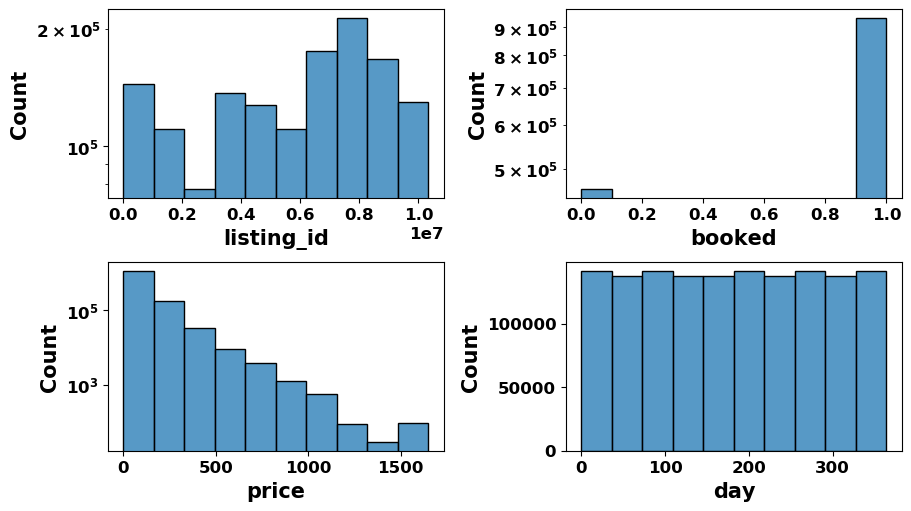

In [11]:
# Check that all quantities follow reasonable ditributions
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=[9,5])
for i,c in enumerate(df_booking.columns.drop("date")):
    ax=axs[i//2,i%2]
    sns.histplot(df_booking[c],bins=10,ax=ax,edgecolor="black", linewidth=1,
                 log_scale=[False,True] if c != "day" else [False,False])
fig.show()

### The distributions of booking data quantities now all look reasonable.  Proceed with examining the market performance using these data.

When no booking takes place, the listing is not making any revenue. Also when there was no booking
the price was not available (was NaN), the price was set to zero.  So the revenue of the property for a given day
will simply equal the price of its booking (and zero when no booking was made).  It is understood that in
order to plot the price, one first has to select the data when booking was made.

In [12]:
df_booking['revenue'] = df_booking['price']

<a id="performance"> </a>
## Performance of the businesses
* [Daily revenue, booking rate, and price](#daily_booking)
* [Mean revenue, booking rate, and price](#mean_booking)
* [Time dependence of price, booking rate, and revenue](#timedep_booking)

<a id="daily_booking"> </a>
### Daily revenue and price over all times over all businesses

In [13]:
def hist_w_stats(x,ax,frm=r'${:.0f}',nm=None):
    sns.histplot(ax=ax,x=x, bins='auto', log_scale=[False,True])
    mean = x.mean()
    std = x.std()
    x1 = mean - std if mean - std > x.min() else x.min()
    x2 = mean + std if mean + std < x.max() else x.max()
    ax.axvline(mean, color='red', linestyle='-', linewidth=2, 
                    label='Mean {:s} = '.format(nm if nm else x.name) + frm.format(mean))
    ax.axvspan(x1, x2, color='red', alpha=0.25, label = 'Std. dev. = ' + frm.format(std))
    ax.legend(loc='best')

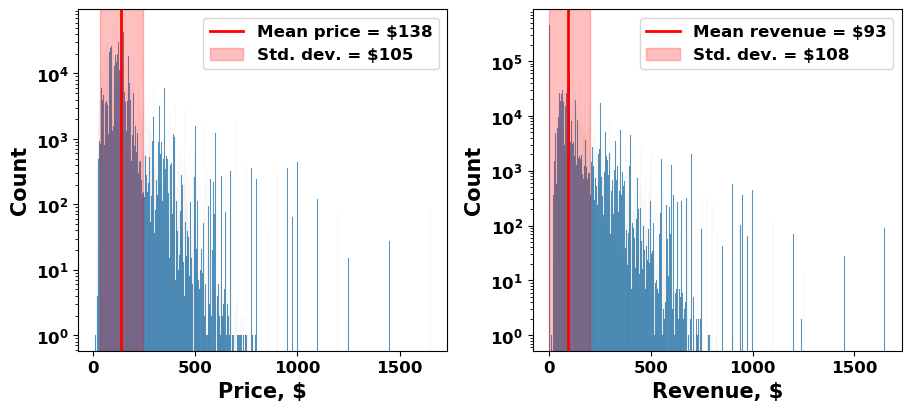

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=[9,4])
hist_w_stats(df_booked["price"],axs[0])
axs[0].set_xlabel("Price, $")
hist_w_stats(df_booking["revenue"],axs[1])
axs[1].set_xlabel("Revenue, $")
fig.show()

<a id="mean_booking"> </a>
### Distributions of host averages (daily price, revenue, and booking rate)

In [15]:
# booking statistics for each host
df_booking_host = pd.DataFrame(index=df_booking["listing_id"].unique())
df_booking_host["mean_booked"] = df_booking.groupby("listing_id")["booked"].mean()
df_booking_host["std_booked"] = df_booking.groupby("listing_id")["booked"].std()
df_booking_host["mean_revenue"] = df_booking.groupby("listing_id")["revenue"].mean()
df_booking_host["std_revenue"] = df_booking.groupby("listing_id")["revenue"].std()
len(df_booking_host[df_booking_host.isna().any(axis=1)])

0

In [16]:
# booked price statistics for each host
df_booked_host = pd.DataFrame(index=df_booked["listing_id"].unique())
df_booked_host["mean_price"] = df_booked.groupby("listing_id")["price"].mean()
df_booked_host["std_price"] = df_booked.groupby("listing_id")["price"].std()
# if not enough entries to compute the standard deviation, then just use the mean as the standard deviation
# (there were only 7 such entries)
df_booked_host["std_price"].fillna(df_booked_host["mean_price"],inplace=True)
len(df_booked_host[df_booked_host.isna().any(axis=1)])

0

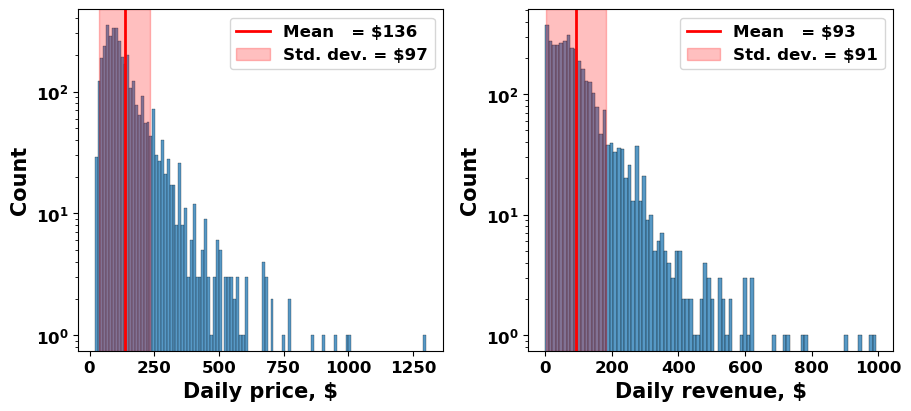

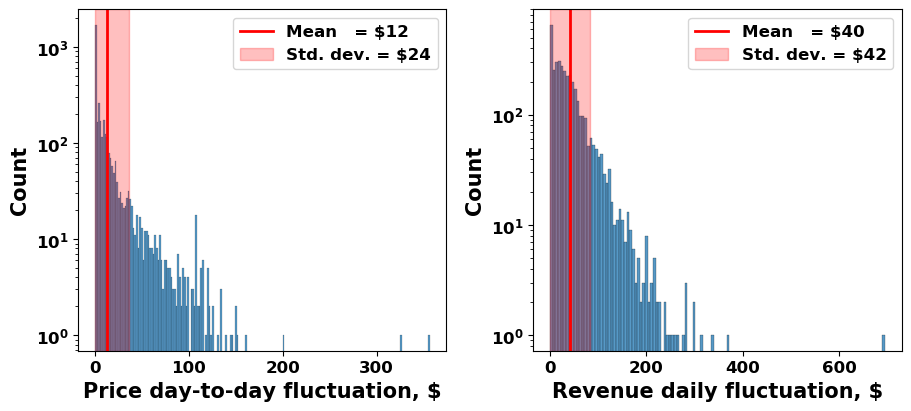

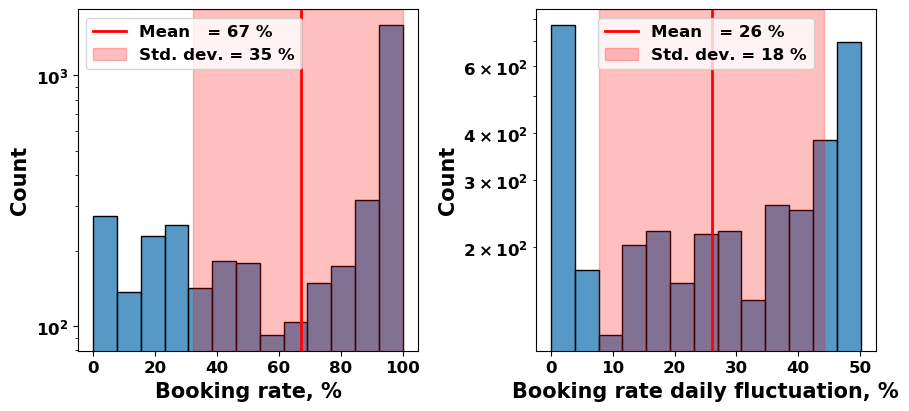

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=[9,4])
hist_w_stats(df_booked_host["mean_price"],axs[0],frm=r'${:.0f}',nm=" ")
axs[0].set_xlabel("Daily price, $")
hist_w_stats(df_booking_host["mean_revenue"],axs[1], frm=r'${:.0f}',nm=" ")
axs[1].set_xlabel("Daily revenue, $")
fig.show()

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=[9,4])

hist_w_stats(df_booked_host["std_price"],axs[0],frm=r"${:.0f}",nm=" ")
axs[0].set_xlabel("Price day-to-day fluctuation, $")
hist_w_stats(df_booking_host["std_revenue"],axs[1],frm=r"${:.0f}",nm=" ")
axs[1].set_xlabel("Revenue daily fluctuation, $")
fig.show()

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=[9,4])
hist_w_stats(100.0 * df_booking_host["mean_booked"],axs[0],frm=r"{:.0f} %",nm=" ")
axs[0].set_xlabel("Booking rate, %")
hist_w_stats(100.0 * df_booking_host["std_booked"],axs[1],frm=r"{:.0f} %",nm=" ")
axs[1].set_xlabel("Booking rate daily fluctuation, %")


fig.show()

##### Businesses without any revenue

In [18]:
df_booking_no_booking = df_booking_host[df_booking_host["mean_booked"]==0]
df_booking_no_revenue = df_booking_host[df_booking_host["mean_revenue"]==0]
len(df_booking_no_booking),len(df_booking_no_revenue),len(df_booking_host)

(95, 95, 3818)

##### There are 95 hosts (out of 3818) without any revenue throughout the whole year

<a id = "timedep_booking"></a>
### Average revenue, booking probability, and price over all businesses for each day versus date. 
* Shaded areas shows 95% confidence intervals

In [19]:
# Function for plotting dailiy quantities versus date.  Also show the 95 confidence limit intervals as shaded area 
# (confidence limit intervals are determined by statistical bootstrapping (https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) using 1000 samples) 
def evolution_plot(ax,estimator,y,x=df_booking["day"]):
    day0=df_booking['date'].min().toordinal()
    ax=sns.lineplot(ax=ax,x=x, y=y, ci = 95, n_boot=1000, estimator=estimator)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels((dt.date.fromordinal(int(day + day0)) for day in ax.get_xticks()), rotation=45)
    ax.grid()

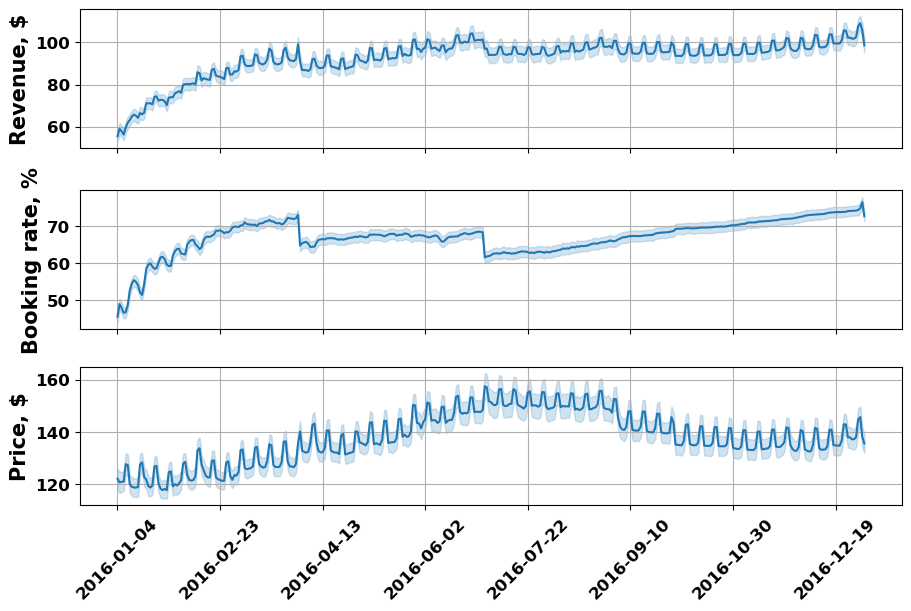

In [20]:
fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True, sharex = True, figsize=[9,6])
evolution_plot(axs[0],estimator=np.mean,y=df_booking["revenue"])
axs[0].set_ylabel("Revenue, $")
evolution_plot(axs[1],estimator = np.mean, y=100.0 * df_booking["booked"])
axs[1].set_ylabel("Booking rate, %")
evolution_plot(axs[2],estimator = np.mean, y = df_booked["price"], x = df_booked["day"])
axs[2].set_ylabel("Price, $")
fig.show()

### Learned from examining the performance of the hosts:
* Revenue is less spread out when day-to-day fluctuations within each business are removed by averaging over each business
* Price averaged over each business is very similar to price over all businesses over all days.  There is much less day-to-day fluctuation in price than there is in revenue because the latter depends on the booking rate.
* 95 out of 3818 businesses had zero booking rate and zero revenue, which means they were either not ready for booking or there was no demand for them. It will be explored below, using listing data, what makes businesses more attractive and what raises their revenue.
* One can clearly see the drops in the booking rate and revenue that correspond to major US holidays
* Christmas and New Year appear have the largest impact on revenue
* Booking rate did not reduce substantially in the summer when the prices were high, this is likely due to
  the increased demand

<a id="listing_data"> </a>
### Loading, cleaning, and validating listing data from "listings.csv"
Since the number of listing variables is very large, first run (in Bash)
```bash
head -1 listings.csv | sed 's/\,/\n/g'
head -1 listings.csv | sed 's/\,/\n/g' | wc -l
```
to see what columns are present.  There are 92 columns of information.

Read the booking information, parse the date column because the booking dates have been provided.  The last line shows that the listing ID is unique to each row.  In other words, each property is identified by its unique ID which can be used to connect it with the information from the booking file.

In [21]:
path_to_downloaded_and_unzipped_listings_csv = "data/listings.csv" # change it as needed
df_listing = pd.read_csv(path_to_downloaded_and_unzipped_listings_csv,delimiter=',', parse_dates=['host_since'])
df_listing["id"].is_unique

True

In [22]:
# listing ID should be used as index for the rows of the listings data 
df_listing.set_index("id",inplace=True)

##### Determining which columns contain useful data 
* First, list the columns and calculate the fraction of hosts with NA or NaN values for those columns.  
* The idea is the select the columns (pieces of information) that are available for the vast majority of hosts.

In [23]:
df_listing_cols={col :  {"fraction_of_hosts_missing" : 1 - df_listing[col].count() / len(df_listing)} for col in df_listing}
df_listing_cols=pd.DataFrame.from_dict(df_listing_cols,orient="index").sort_values(by="fraction_of_hosts_missing",ascending=False)

### Use only columns (pieces of information) such that less than 1% of all hosts are missing them. Such choice is justified as long as:
* The most important information that affects revenue and booking probability remains (this has been checked by going back and loosening the selection criteria)
* The overall proportion of such columns isn't too large, as it can be checked by plotting the distribution of the missing data fractions over all columns.

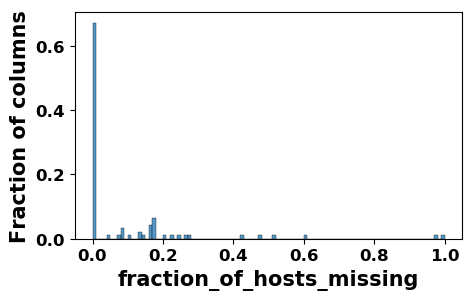

In [24]:
df_listing_cols["weights"] = np.ones(df_listing_cols.shape[0]) / df_listing_cols.shape[0]
fig=plt.figure(figsize=(5, 3))
ax=sns.histplot(data=df_listing_cols, x = "fraction_of_hosts_missing", bins=100, weights="weights")
ax.set_ylabel("Fraction of columns")
fig.show()

In [25]:
df_listing_cols.drop(df_listing_cols.index[df_listing_cols['fraction_of_hosts_missing'] >= 0.01],inplace=True)

## Reduce the data
* Remove repetitive data
* Remove data that are too specific
* Remove data that are too general
* Construct features
* Trim the outliers with missing data if their percentage is small, otherwise find ways to estimate / impute
  the missing data, whenever it is possible to do so without introducing spurious features

##### Remove repetitive data (columns that repeat other columns or the information available through another data base)

In [26]:
df_listing_cols.drop(["host_total_listings_count","host_listings_count",
                      "availability_30","availability_60","availability_90","availability_365"],inplace=True)

##### Remove data that are too specific to each host (e.g. name, URL, thumbnail URL, etc)

In [27]:
df_listing_cols.drop(["zipcode","host_name","host_id","host_thumbnail_url", "host_picture_url", 
                      "street", "experiences_offered", "description", "calendar_updated", 
                     "calendar_last_scraped", "scrape_id", "host_url", "last_scraped", "latitude", 
                      "listing_url","longitude","name", "neighbourhood_cleansed", "picture_url"], inplace=True)

##### Remove data that are too general (e.g. Country, Country code, city, etc) because all hosts are in Seattle area

In [28]:
df_listing_cols.drop(["host_location","country_code","country","city","smart_location", "state", 
                      "host_verifications", "jurisdiction_names", "market", "requires_license"], inplace=True)

##### Update the listing data frame to contain only the wanted columns

In [29]:
df_listing = df_listing[df_listing_cols.index]

##### Check what and how much information is missing

In [30]:
x=df_listing.isna().any(axis=0)
print(x[x==True])
x=df_listing[df_listing.isna().any(axis=1)]
print("{:d} out of {:d} businesses have these data missing".format(len(x),len(df_listing)))

bathrooms                 True
bedrooms                  True
host_is_superhost         True
host_since                True
host_has_profile_pic      True
host_identity_verified    True
beds                      True
property_type             True
dtype: bool
25 out of 3818 businesses have these data missing


##### Since only a tiny portion of businesses have the above information missing, those businesses can be removed as outliers


In [31]:
df_listing.dropna(how="any",axis=0,inplace=True)
print(df_listing[df_listing.isna().any(axis=1)].shape[0])

0


##### Convert host_since variable to host experience measured in numbers of days before the data set begins 

In [32]:
day0 = df_booking['date'].min().toordinal()
df_listing['experience'] = df_listing['host_since'].apply(lambda dt: (day0 - dt.date().toordinal())/365.25)
df_listing.drop("host_since",axis=1,inplace=True)

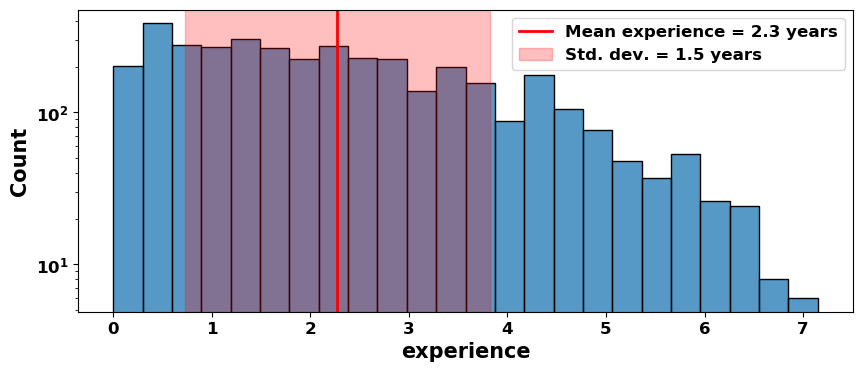

In [33]:
fig,ax=plt.subplots(figsize=[10,4])
hist_w_stats(df_listing["experience"],ax=ax,frm=r"{:.1f} years",nm="experience")
fig.show()

In [34]:
# convert all prices to float numbers and all true/false to 1 or 0
df_listing.replace(r'\$(\d*),?(\d*)(\.?\d*)', r'\1\2\3', regex = True, inplace = True)
df_listing.replace({'t' : 1, 'f' : 0}, inplace = True)
non_numeric=["property_type", "room_type", "cancellation_policy", "bed_type", "amenities", "neighbourhood_group_cleansed"  ]
cols = df_listing.columns.drop(non_numeric)
df_listing[cols] = df_listing[cols].apply(pd.to_numeric,errors='coerce')

### Parse the amenities column, extract useful features

In [35]:
extact_amenities={"has_tv": "tv",
                  "has_internet": "internet",
                  "has_free_parking": "free parking", 
                  "has_kitchen" : "kitchen", 
                  "has_pool" : "pool"}
for key,val in extact_amenities.items():
    df_listing[key] = df_listing["amenities"].apply(lambda x: 1 if val in x.lower() else 0 )
df_listing.drop("amenities",axis=1,inplace=True)

##### Join the listing data with the booking stats data 
* Impute the missing mean and standard deviation price information using listing price
* Check that there are no more missing entries

In [36]:
df_listing=df_listing.join(df_booking_host).join(df_booked_host)
df_listing["mean_price"].fillna(df_listing["price"],inplace=True)
df_listing.drop("price",axis=1,inplace=True)
df_listing["std_price"].fillna(df_listing["mean_price"],inplace=True)
len(df_listing[df_listing.isna().any(axis=1)])

0

In [37]:
# Check if has_availability is different for any rows from 1
(1-df_listing["has_availability"]).any()

False

In [38]:
# Since has_availability is the same for all entries, it's not needed
df_listing.drop("has_availability",axis=1,inplace=True)

##### Numbers of guests included and number of people accommodated have been mixed up in the reports for some businesses
There are 22 businesses where the number of included guests is more than the number of accommodated people. After considering numbers of beds, it is clear that such scenarios are impossible.  These businesses are therefore excluded from further analysis because their fraction (22 out of 3784) is small and they will produce inconsistent results

In [39]:
print(len(df_listing))
df_listing.drop(df_listing[df_listing["accommodates"] < df_listing["guests_included"]].index,inplace=True)
print(len(df_listing))

3793
3771


##### Also some businesses report the numbers of guests included as the number of accommodated people.  This is fixed by imputing the most probable value for the number of guests included.

In [40]:
# most probable value for the number of guests
mpv_guests_included = df_listing["guests_included"].value_counts().idxmax()
mpv_guests_included

1

In [41]:
df_listing.loc[df_listing["accommodates"] == df_listing["guests_included"],"guests_included"] = mpv_guests_included

<a id="variables_and_features"> </a>
## Select variables and features that are affecting the revenue

In [42]:
features = {}

<a id = "select_categorical_features"> </a>
### Consider categorical non-binary features

In [43]:
# First, consider a set of categorical (but not binary yes-no) features
features["categorical"] = set([])

##### How the property types affect the revenue

In [44]:
# calculate the stats that correspond to a categorical feature and and store 
# them in a data frame sorted by revenue
def get_categorical_feature_stats(feature):
    
    # calculate the mean values as well as counts (numbers of hosts in each category)
    mean=df_listing.groupby(feature)["mean_revenue","mean_price","mean_booked"].mean()
    std=df_listing.groupby(feature)["mean_revenue","mean_price","mean_booked"].std()    
    std.columns=["std_revenue","std_price","std_booked"]
    
   
    df=mean.join(std)
    df["std_revenue"].fillna(df["mean_revenue"],inplace=True)
    df["std_price"].fillna(df["mean_price"],inplace=True)
    df["std_booked"].fillna(df["mean_booked"],inplace=True)
    df["count"] = df_listing[feature].value_counts()
    
    df.sort_values(by="mean_revenue",ascending=False,inplace=True)
    
    # calculate the uncertainties (standard deviations of means) for the plots
    df["count_err"] = df["count"]**0.5
    df["count_err"].apply(lambda x: 1 if x == 0 else x)
    df["mean_revenue_err"] = df["std_revenue"] / df["count_err"]
    df["mean_price_err"] = df["std_price"] / df["count_err"]
    df["mean_booked_err"] = df["std_booked"] / df["count_err"]
    df["count_err"] = df["count"]**0.5
    
    df["mean_booked_pc"] = 100.0 * df["mean_booked"]
    df["mean_booked_pc_err"] = 100.0 * df["mean_booked_err"]
    
    return df

# plot the effects of the category on revenue and booking rate and also show the average prices and
# numbers of hosts in each category
def plot_categorical_feature_impact(feature,log=[False,False,False,True],
                                    figsize=[9,5],how="v",rot=0,title="",width=None):    
    how=how.lower()
    if how not in ["v","h"]:
        how = "v"
    spines = ["left","right"] if how == "v" else ["top","bottom"]
    opt_log = log if(type(log) == list or type(log) == tuple) else [log]*4
    def style_axes(ax,spine,label,color):    
        for sp in spines:
            ax.spines[sp].set_visible(False)
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color(color)
        if(how == "v"):
            ax.yaxis.label.set_color(color)
            ax.tick_params(axis='y', colors=color)
            ax.set_ylabel(label)
            ax.set_xlabel("")
        else:
            ax.xaxis.label.set_color(color)
            ax.tick_params(axis='x', colors=color)
            ax.set_xlabel(label)
            ax.set_ylabel("")
    def plot_pair(df,ax,colnames,labels,colors,log):
        axs = [ax,ax.twinx()] if how == "v" else [ax.twiny(),ax]
        for i in range(0,2):
            ax=axs[i]
            if(how == "v"):
                df.plot.bar(ax=ax,y=colnames[i], width = width if width else 0.2, position=1-i, color=colors[i], 
                            log = log[i], yerr=colnames[i]+"_err", legend = False)
            else:
                df.plot.barh(ax=ax,y=colnames[i], width = width if width else 0.4, position=i, color=colors[i], 
                            log = log[i], xerr=colnames[i]+"_err", legend = False)
            style_axes(ax,spines[i],labels[i],colors[i])
        return axs
    df = get_categorical_feature_stats(feature)
    if(how == "h"):
        df.sort_values(by="mean_revenue",ascending=True,inplace=True)
    
    if(how == "v"):
        fig, axs = plt.subplots(nrows=2, ncols=1,constrained_layout=True,  sharex = True, figsize=figsize)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2,constrained_layout=True,  sharey = True, figsize=figsize)
    axs[0].set_title(title)
    p1_axs = plot_pair(df=df,ax=axs[0],colnames=["mean_revenue","mean_booked_pc"],
                  labels=["Revenue, $","Booking rate, %"],
                  colors=["firebrick","teal"],log=opt_log[:2])
    p2_axs = plot_pair(df=df,ax=axs[1],colnames=["mean_price","count"],
                  labels=["Price, $","Number of hosts"],
                  colors=["orangered","steelblue"],
                  log=opt_log[2:])
    if(how == "v"):
        for a in p2_axs:
            a.set_xticklabels(a.get_xticklabels(), rotation=rot)
            a.set_xticklabels(a.get_xticklabels(), rotation=rot)
            a.set_xlim(left=-0.4,right=0.4+df.shape[0]-1)
    else:
        for a in p1_axs:
            a.set_yticklabels(a.get_yticklabels(), rotation=rot)
            a.set_yticklabels(a.get_yticklabels(), rotation=rot)
            a.set_ylim(bottom=-0.6,top=0.6+df.shape[0]-1)
            
    for ax in axs:
        ax.grid()
        
    return fig, p1_axs + p2_axs

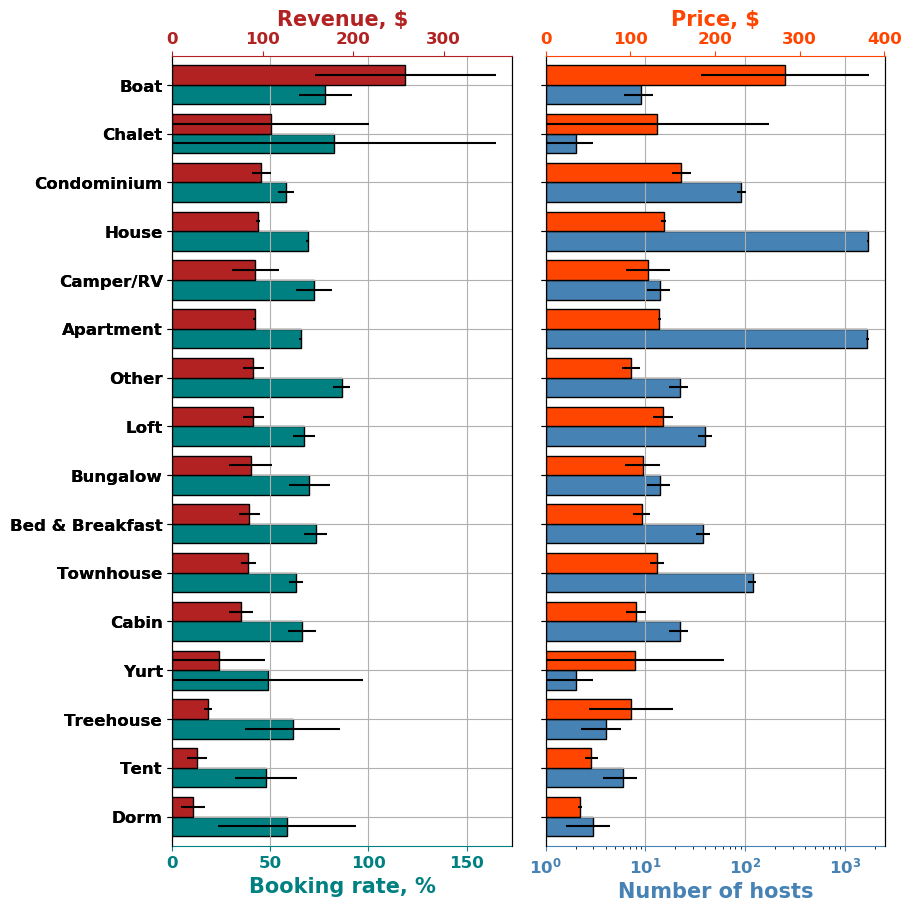

In [45]:
_, __ = plot_categorical_feature_impact("property_type",figsize=[9,9],how="h")

##### (BELOW) Check the function "plot_categorical_feature_impact" with a simple seaborn barplot routine (which offers less flexibility)
* In some cases, seaborn fails to show the error bars.  This is because seaborn by default doesn't impute errors when there is only one measurement available.
* In the routine "plot_categorical_feature_impact", however, the values themselves are used as error bars in cases when there's insufficient data to calculate the error bars.
* Also, the above routine allows plotting two useful quantities on the same plot using different axis scales.

Text(0.5, 0, 'Revenue, $')

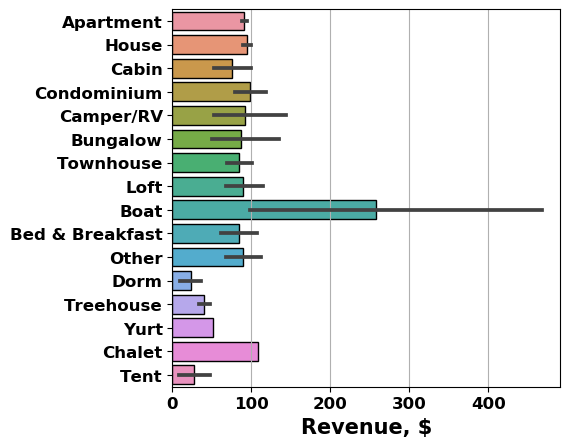

In [46]:
fig, ax = plt.subplots(figsize=[5,5])
ax.grid()
_ = sns.barplot(ax=ax,data=df_listing,x="mean_revenue",y="property_type")
ax.set_ylabel("")
ax.set_xlabel("Revenue, $")

##### It's clear that Chalet, Yurt, Dorm, and Tent property types have large booking rate fluctuations and don't have sufficient numbers of hosts to accurately measure average booking rate and revenue

In [47]:
df_listing.drop(df_listing[df_listing['property_type'].isin(["Chalet", "Yurt", "Dorm", "Tent"])].index, inplace = True)

##### Property type impact on booking rate and revenue
* Although places on boats appear to generate more revenue than other property types, the prediction
has a large uncertainty due to relatively large price and booking rate fluctuations throughout the year and relatively small number of such hosts.
* Condominiums, houses, apartments, Camper/RV generate relatively large revenue, in that order
* Tents and treehouses generate the least amounts of revenue, on average, and their booking probability fluctuates considerably due to the obvious seasonal dependence of their services. Also the number of such hosts is relatively small.

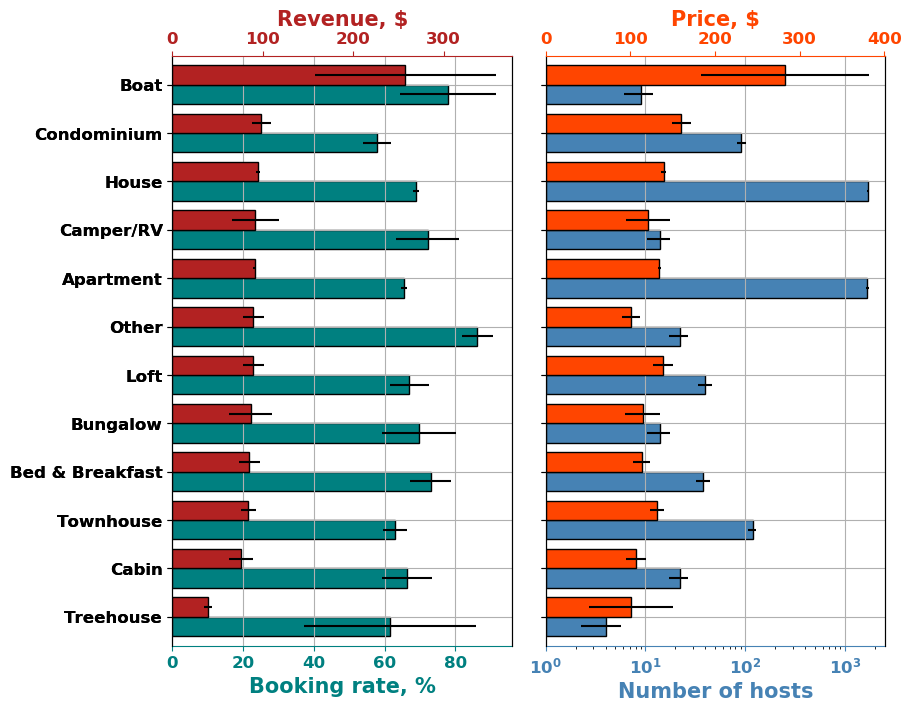

In [48]:
features["categorical"].add("property_type")
_, __ = plot_categorical_feature_impact("property_type",figsize=[9,7],how="h",rot=0)

##### Room type
* Plots below show that renting out entire houses/apartments, rather than single rooms, generates more revenue
* There is a substantial booking rate for shared rooms however

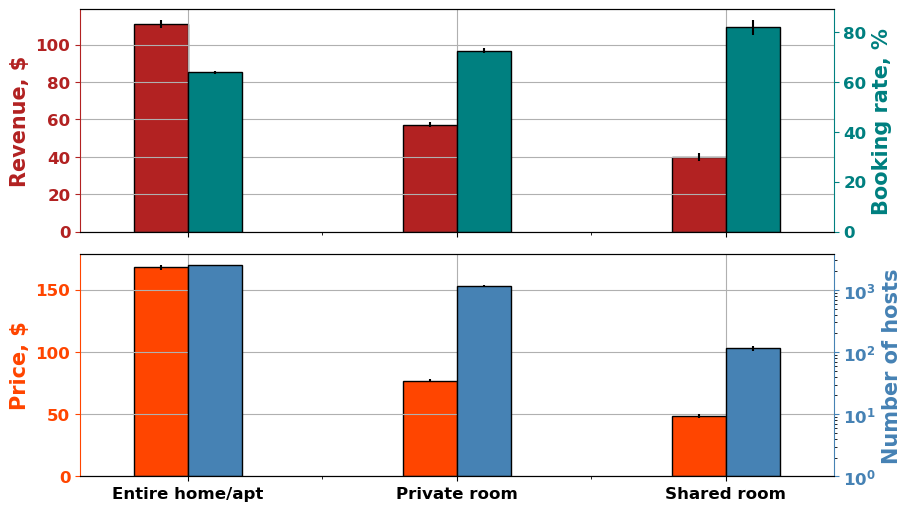

In [49]:
features["categorical"].add("room_type")
_, __ = plot_categorical_feature_impact("room_type",how="v", rot=0)

##### Bed type
* As the plot below shows, the highest revenue option is real bed

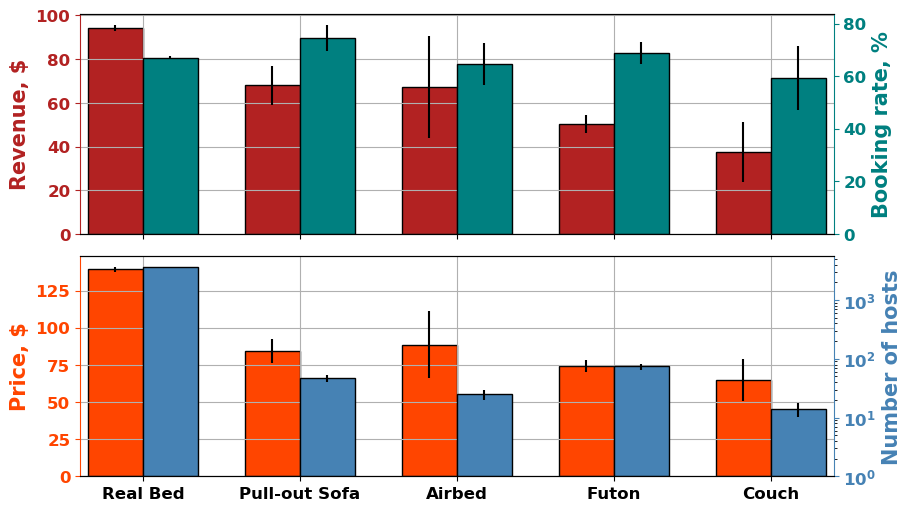

In [50]:
features["categorical"].add("bed_type")
_,__=plot_categorical_feature_impact("bed_type",how="v",width=0.35)

##### Neighborhood.  The plots below show that
* The highest revenue option is Magnolia and Downtown
* The smallest revenue option is Rainier Valley

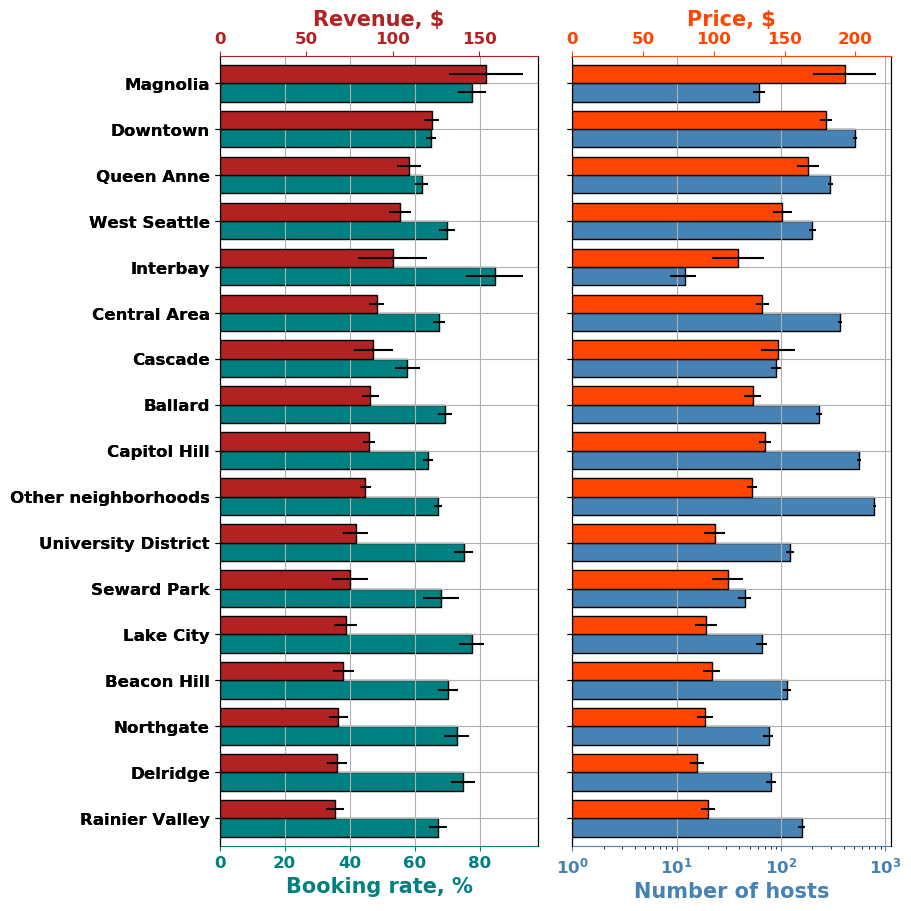

In [51]:
df_listing.rename(columns={"neighbourhood_group_cleansed" : "neighborhood"},inplace=True)
features["categorical"].add("neighborhood")
fit,ax = plot_categorical_feature_impact("neighborhood",how="h",figsize=[9,9])

##### Cancellation policy
* It's clear that the strict cancellation policy is results in both higher revenue and in higher booking probability

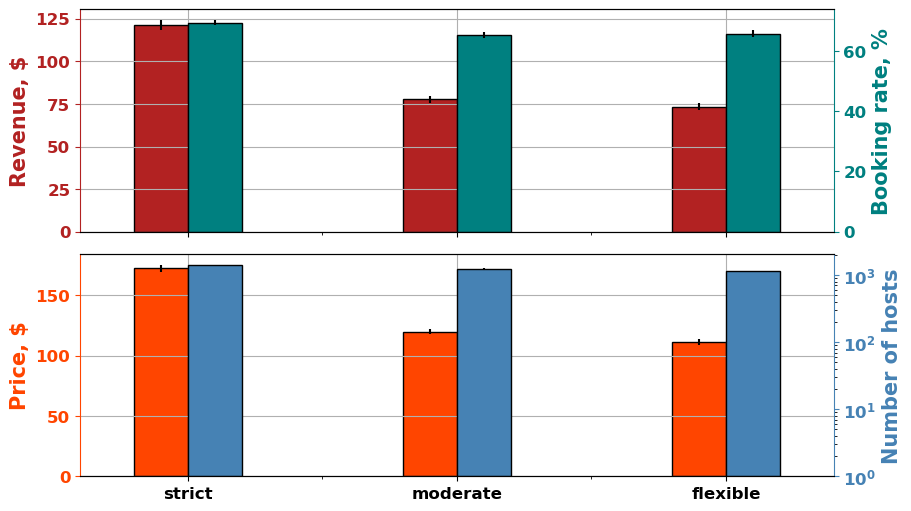

In [52]:
features["categorical"].add("cancellation_policy")
fig,ax = plot_categorical_feature_impact("cancellation_policy",figsize=[9,5])

### Check the cross-correlation among the categorical variables using Cramer's V test.  
* As the plot of Cramer's V statistic shows, these categorical variables do not correlate strongly with each other, given that the maximum
  value of Cramer's V statistic is 1.

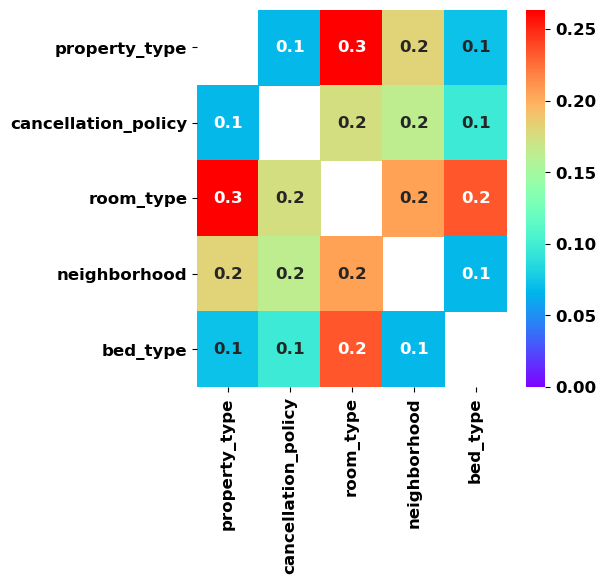

In [53]:
def plot_cramerv(categorical_variables,ax=None):
    df_cramerv=pd.DataFrame(index=categorical_variables,columns=categorical_variables).astype(float)
    df=df_listing[categorical_variables]
    for x in categorical_variables:
        for y in categorical_variables:
            ct=pd.crosstab(df[x],df[y]).values
            n=ct.sum()
            k = min(ct.shape)-1
            chi2=stats.chi2_contingency(ct,lambda_=1)
            df_cramerv[x][y]=np.sqrt(chi2[0]/n/k)
    _ = sns.heatmap(df_cramerv[df_cramerv<0.99],annot=True,fmt=".1f",vmin=0.0, cmap=plt.get_cmap('rainbow'),ax=ax)

fig,ax = plt.subplots(figsize=[5,5])
plot_cramerv(categorical_variables=features["categorical"],ax=ax)
fig.show()

<a id = "select_binary_features"> </a>
### Next, check which binary (1=YES/0=NO) features affect the revenue and the booking probability

In [54]:
features["binary"]=set(['host_is_superhost','host_has_profile_pic','host_identity_verified','require_guest_profile_picture','require_guest_phone_verification',
                     'instant_bookable','is_location_exact','has_tv','has_internet','has_free_parking','has_kitchen','has_pool'])

In [55]:
# return the difference of the average revenues when yes and no, and the combined (in quadrature) error
def get_binary_feature_revenue_difference(feature):
    yes = df_listing[df_listing[feature] == 1][["mean_revenue","mean_booked","mean_price"]]
    yes_mean=yes.mean()
    yes_mean_err=yes.std()/(len(yes))**0.5
    no = df_listing[df_listing[feature] == 0][["mean_revenue","mean_booked","mean_price"]]
    no_mean=no.mean()
    no_mean_err=no.std()/(len(no))**0.5
    delta = yes_mean-no_mean
    err = (yes_mean_err**2+no_mean_err**2)**0.5
    ttest_significance = (delta/err)["mean_revenue"] # significance estimate
    # if the significance is less than 5 standard deviations then do Student's T-test
    if ttest_significance < 5:
        ttest_pvalue = stats.ttest_ind(a = df_listing[df_listing[feature]==1]["mean_revenue"].to_numpy(),
                               b = df_listing[df_listing[feature]==0]["mean_revenue"].to_numpy(),
                               axis=0, equal_var=True, nan_policy='raise').pvalue
        ttest_significance = stats.norm.ppf(1-ttest_pvalue) * np.sign(ttest_significance)
    return [*delta,*err,ttest_significance]

##### As plots below show
* has_pool has a large positive correlation with booking rate, price, and revenue.  Perhaps larger properties are more likely to have a pool.
* has_internet doesn't correlate strongly with the revenue.  This might be due to the vacation nature of these   businesses
* host_has_profile_pic correlation with revenue is well within its error, which is large. Therefore  host_has_profile_pic variable is not useful.
* require_guest_profile_picture has a positive correlation with the revenue
* host_is_superhost, instant_bookable have very little correlation with the revenue and booking rate
* is_location_exact has negative correlation with booking rate but very little correlation with revenue
* has_tv has a positive correlation on revenue and relatively small correlation with booking rate.  Rooms with TVs are in   demand.
* has_kitchen has a positive correlation with revenue via increased price because it's demanded.
* require_guest_profile_picture has a positive correlation on the revenue
* has_free_parking appears to do little to the booking rate but it correlates  with the revenue.
* instant_bookable appears to have little correlation with revenue

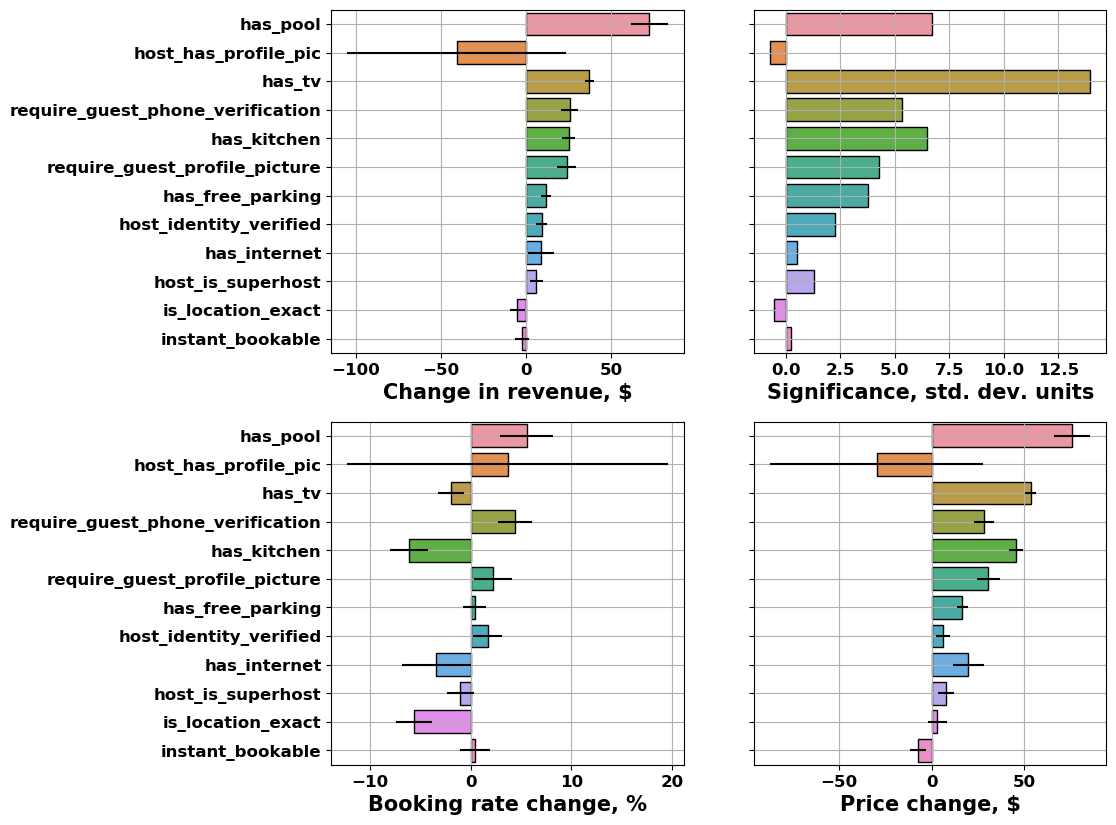

In [56]:
def plot_binary_features():
    df_binary_features=pd.DataFrame.from_dict({ feature: get_binary_feature_revenue_difference(feature) 
                                               for feature in features["binary"] },
                                              orient='index',
                                              columns=["delta_revenue","delta_booked","delta_price",
                                                      "delta_revenue_err","delta_booked_err","delta_price_err",
                                                      "ttest_significance"])
    df_binary_features = df_binary_features.loc[df_binary_features["delta_revenue"].abs().sort_values(ascending=False).index]
    fig,axs=plt.subplots(nrows=2,ncols=2,sharey = True, figsize=[10,10])
    _ = sns.barplot(ax=axs[0,0],y=df_binary_features.index,
                    x=df_binary_features["delta_revenue"],
                    xerr=df_binary_features["delta_revenue_err"])
    _=axs[0,0].set_xlabel("Change in revenue, $")
    _ = sns.barplot(ax=axs[0,1],y=df_binary_features.index,
                    x=df_binary_features["ttest_significance"])
    _=axs[0,1].set_xlabel("Significance, std. dev. units")
    _ = sns.barplot(ax=axs[1,0],y=df_binary_features.index,
                    x=100.0*df_binary_features["delta_booked"],
                    xerr=100.0*df_binary_features["delta_booked_err"])
    _=axs[1,0].set_xlabel("Booking rate change, %")
    _ = sns.barplot(ax=axs[1,1],y=df_binary_features.index,
                    x=df_binary_features["delta_price"],
                    xerr=df_binary_features["delta_price_err"])
    _=axs[1,1].set_xlabel("Price change, $")
    for row in axs:
        for d in row:
            d.grid()
plot_binary_features()

In [57]:
remove=set(["host_has_profile_pic","instant_bookable"])
df_listing.drop(remove,axis=1,inplace=True)
features["binary"] -= remove

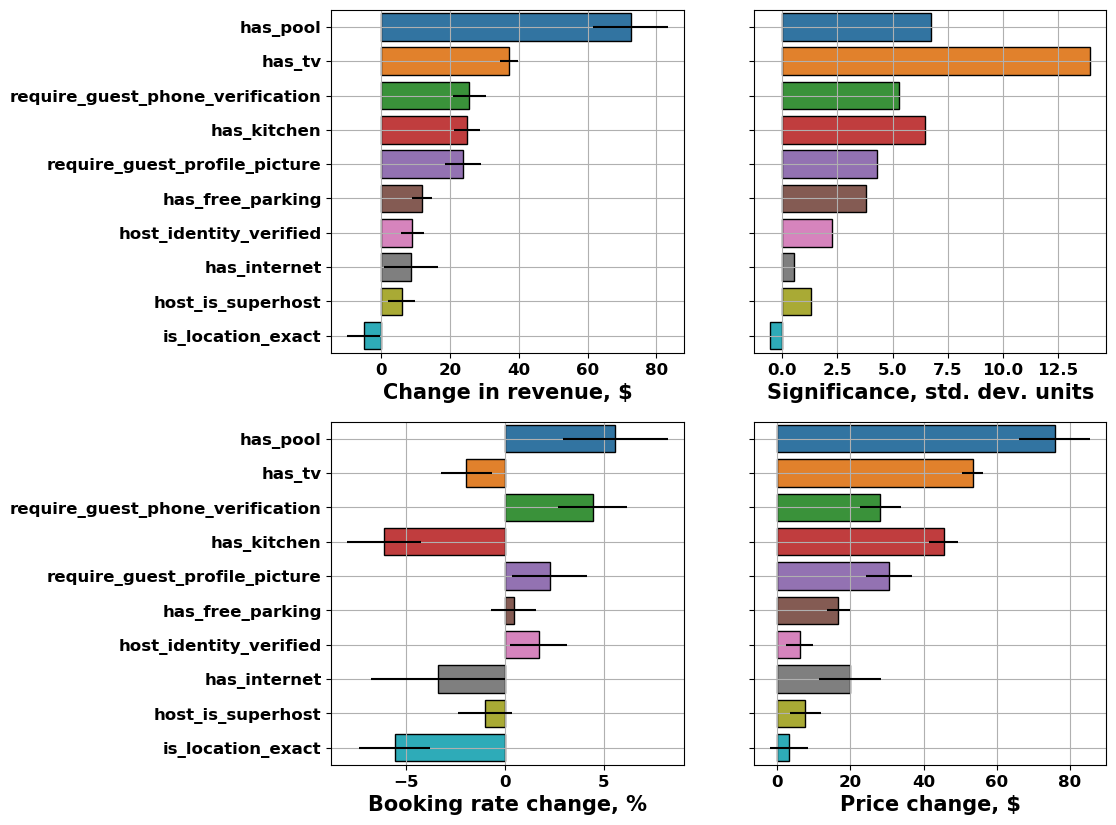

In [58]:
plot_binary_features()

<a id = "select_numeric_features"> </a>
### Examining all numeric variables for correlations with revenue and booking rate.  The plots below show that in addition to the observations above:
* Booking price, as expected, has a significant positive correlation with the revenue
* Number of accommodated people has a significant positive correlation with the revenue
* Numbers of beds, bedrooms, guests all correlate positively with revenue
* Host's experience helps both revenue and the booking rate
* Host's numbers of reviews and numbers of listings although correlate positively with the booking rate, have a very small correlation with the revenue

In [59]:
features["target"] =set(["mean_revenue","std_revenue","mean_booked","std_booked"])
# simplify the long names
df_listing.rename(columns={"calculated_host_listings_count":"listings_counter"},inplace=True)
features["numeric"] = set(df_listing.columns) - features["categorical"] - features["target"]

In [60]:
# Calculate the correlation coefficients between mean revenue and all of the numeric variables, sort them by
# the absolute value of the correlation, and also add the correlation with the booking rate to the data frame
def get_corr():
    r=df_listing[["mean_revenue"] + list(features["numeric"])].corr().stack()["mean_revenue"].drop("mean_revenue")
    r=pd.concat([r,r.abs()],axis=1,keys=["corr","abs_corr"]).sort_values(by="abs_corr",ascending=False)
    r["corr_booked"] = df_listing[["mean_booked"] + list(features["numeric"])].corr().stack()["mean_booked"].drop("mean_booked")
    return r
def plot_corr(r):
    fig,axs=plt.subplots(nrows=1,ncols=2,sharey=True,figsize=[9,7])
    _ = sns.barplot(ax=axs[0],data=r,x="corr",y=r.index)
    axs[0].set_xlabel("Correlation with revenue")
    _ = sns.barplot(ax=axs[1],data=r,x="corr_booked",y=r.index)
    axs[1].set_xlabel("Correlation with booking rate")
    for ax in axs:
        ax.grid()

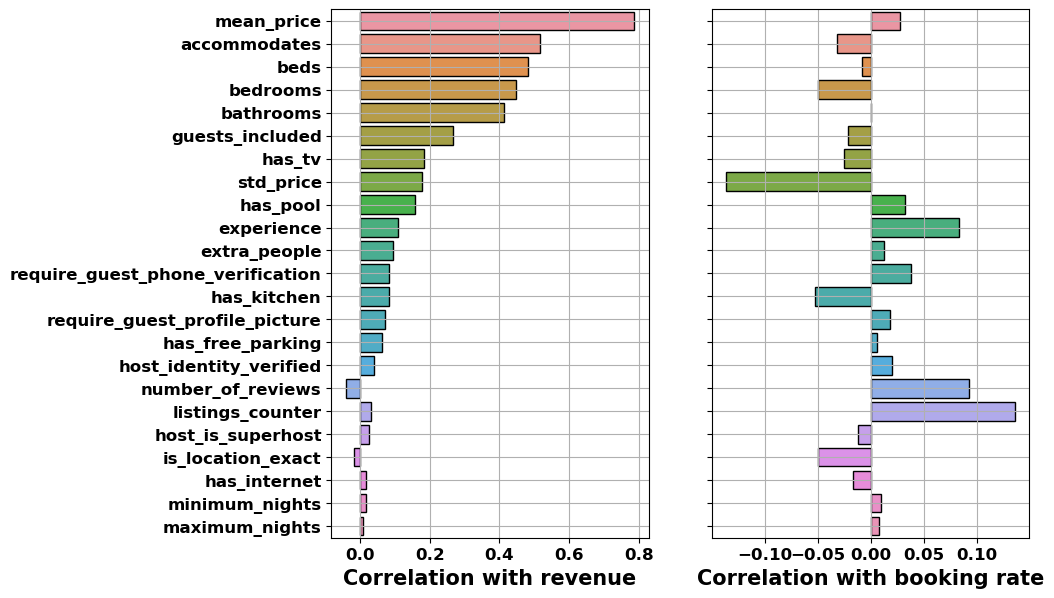

In [61]:
corr = get_corr()
plot_corr(corr)

##### Remove variables which don't sufficiently correlate with revenue and booking rate. A cut point is anything at or below "host_is_superhost" 

In [62]:
min_corr = np.abs(corr["corr"]["host_is_superhost"])
remove=set(corr[corr["corr"] <= min_corr].index)
df_listing.drop(remove,axis=1,inplace=True)
features["numeric"] -= remove
for feature in remove:
    if feature in features["binary"]:
        features["binary"] -= remove

##### Below is the same plot as the above except the variables that don't sufficiently correlate with the revenue and booking rate have been removed

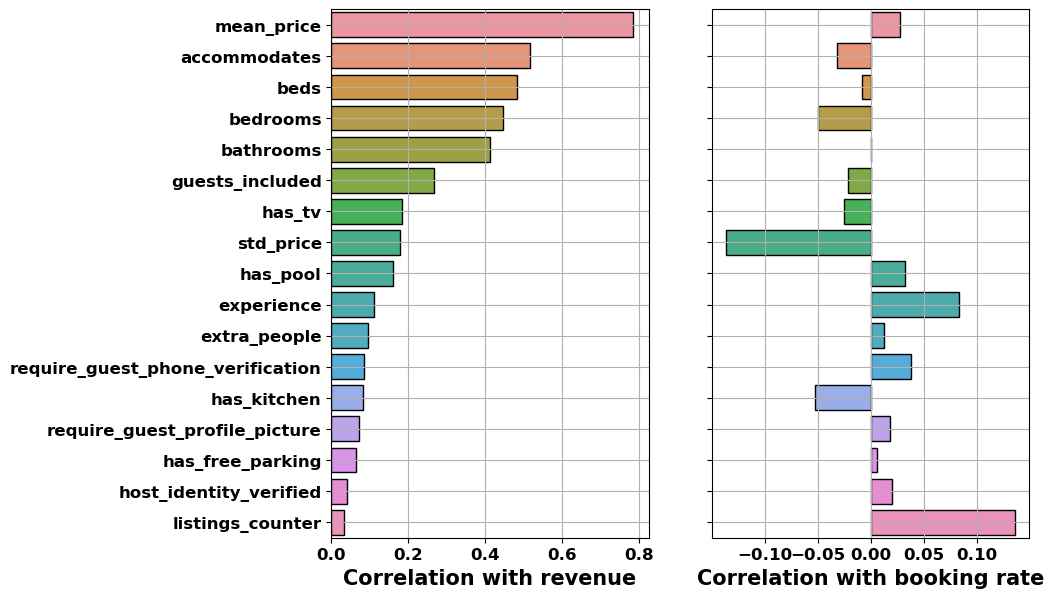

In [63]:
plot_corr(get_corr())

In [64]:
def get_large_corr(thresh=0.5):
    corr = df_listing[features["numeric"]].corr()
    large_corr = []
    rows = list(corr.index)
    cols = list(corr.columns)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            r = corr.iloc[i,j]
            if(np.abs(r) > thresh):
                large_corr.append([r,rows[i],cols[j]])            
    return sorted(large_corr,reverse=True,key=lambda x: np.abs(x[0]))

##### Checking whether the selected numeric variables have strong correlations among themselves shows that 
* require_guest_profile_picture, require_guest_phone_verification are very strongly correlated
* number of beds, bedrooms, and accommodates are also very strongly correlated
* price and people accommodated are strongly correlated also

In [65]:
get_large_corr()

[[0.8751671620168566,
  'require_guest_profile_picture',
  'require_guest_phone_verification'],
 [0.8635868548531721, 'accommodates', 'beds'],
 [0.7736287848889011, 'accommodates', 'bedrooms'],
 [0.7610871398449949, 'bedrooms', 'beds'],
 [0.6927034041865017, 'mean_price', 'accommodates'],
 [0.6414891694625539, 'mean_price', 'bedrooms'],
 [0.6328020319170969, 'mean_price', 'beds'],
 [0.6247732171917023, 'bathrooms', 'bedrooms'],
 [0.5837471751528305, 'guests_included', 'accommodates'],
 [0.5461989029421096, 'bathrooms', 'mean_price'],
 [0.5441142372656792, 'bathrooms', 'accommodates'],
 [0.533772090985463, 'bathrooms', 'beds']]

### Transform and reduce the variables as follows:
* Transform (price, std_price) into price_per_customer and std_price_norm, where std_price_norm is the price fluctuation (standard deviation) normalized by the price
* Represent (require_guest_profile_picture,require_guest_phone_verification) by require_guest_verification
* Represent (beds,bedrooms,bathrooms,accommodates,guests_included) by accommodates, bathrooms_per_bedroom, and extra_guest_fraction 

In [66]:
# Combine (price, guests_included, std_price) into price_per_customer and std_price_norm
add=set(["price_per_customer","std_price_norm"])
remove=set(["mean_price","std_price"])
df_listing["price_per_customer"] = df_listing["mean_price"] / df_listing["accommodates"]
df_listing["std_price_norm"] = df_listing["std_price"] / df_listing["mean_price"]
df_listing.drop(remove,axis=1,inplace=True)
features["numeric"] -= remove
features["numeric"] |= add

In [67]:
# Represent (require_guest_profile_picture,require_guest_phone_verification) by require_guest_verification
add=set(["require_guest_verification"])
remove=set(["require_guest_profile_picture","require_guest_phone_verification"])
df_listing["require_guest_verification"] = df_listing["require_guest_profile_picture"] | df_listing["require_guest_phone_verification"]
features["numeric"] |= add
features["binary"]  |= add
df_listing.drop(remove,axis=1,inplace=True)
features["numeric"] -= remove
features["binary"] -= remove

In [68]:
# Impute the missing number of beds information: it's number of people accommodated divided by 2
df_listing.loc[df_listing["bedrooms"]==0,"bedrooms"] = df_listing.loc[df_listing["bedrooms"]==0,"accommodates"]/2
df_listing.loc[df_listing["bedrooms"] < 1,"bedrooms"] = 1

In [69]:
# Represent (beds,bedrooms,bathrooms,accommodates,guests_included) by accommodates, bathrooms_per_bedroom, and extra_guest_fraction
add=set(["bathrooms_per_bedroom","extra_guest_fraction"])
remove=set(["beds","bedrooms","bathrooms","guests_included"])
df_listing["bathrooms_per_bedroom"] = df_listing["bathrooms"] / df_listing["bedrooms"]
df_listing["extra_guest_fraction"] = df_listing["guests_included"] / df_listing["accommodates"]
features["numeric"] |= add
df_listing.drop(remove,axis=1,inplace=True)
features["numeric"] -= remove

In [70]:
get_large_corr()

[]

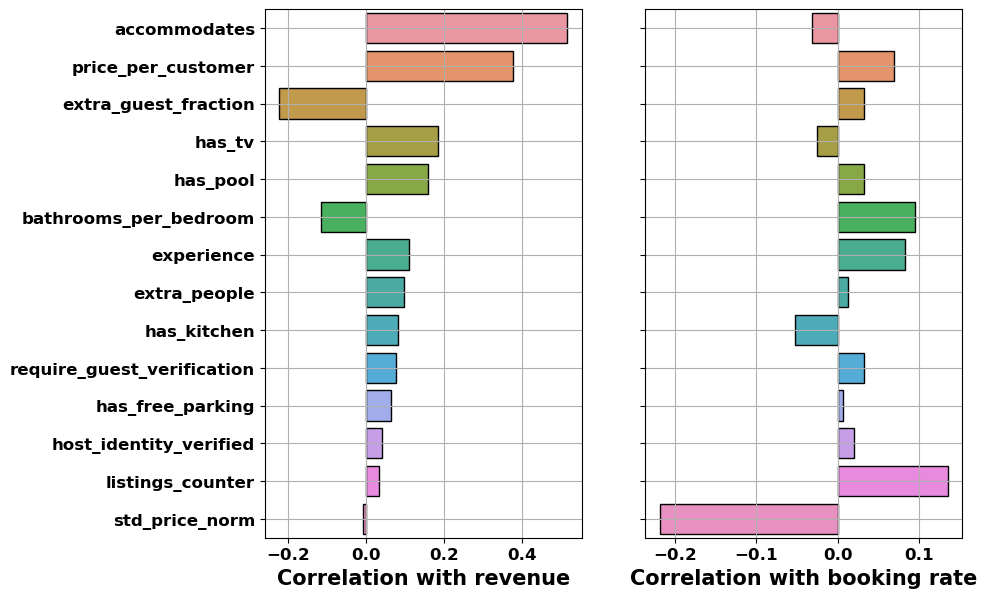

In [71]:
plot_corr(get_corr())

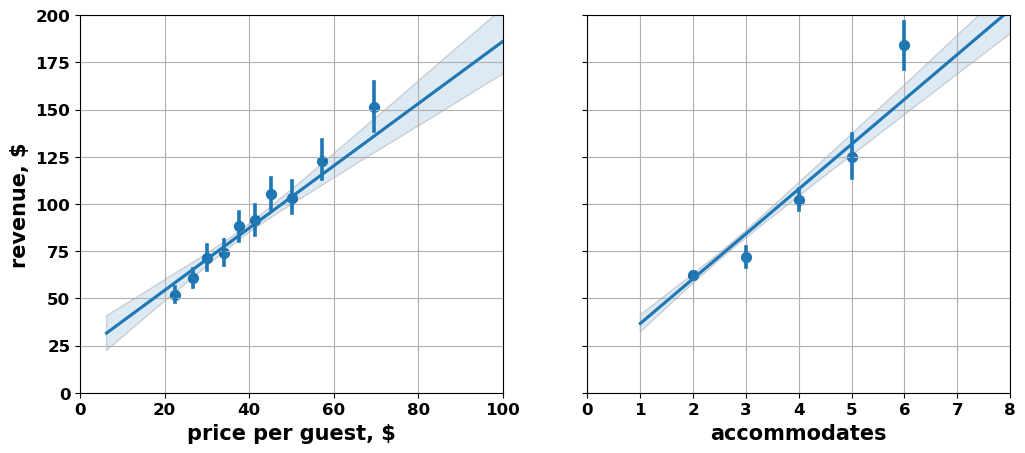

In [72]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharey=True,figsize=[12,5])
sns.regplot(data=df_listing,y="mean_revenue",x="price_per_customer",x_bins=10,ax=axs[0])
axs[0].set_ylabel("revenue, $")
axs[0].set_xlabel("price per guest, $")
axs[0].set_xlim(0,100.0)
sns.regplot(data=df_listing,y="mean_revenue",x="accommodates",x_bins=10,ax=axs[1])
axs[1].set_xlim(0,8)
axs[1].set_ylim(0,200)
axs[1].set_ylabel("")
for ax in axs:
    ax.grid()
fig.show()

##### It is now clear that:
* Price per guest and the number of accommodations have a clear positive correlation with the revenue and their correlations with booking rate are small.  Extra guest fraction has a negative correlation with the revenue.
* Relative price fluctuation has a stronger negative correlation with the booking rate but small correlation with revenue
* Having more bathrooms per bedroom although correlates positively with the booking rate but it has a negative effect on the revenue.

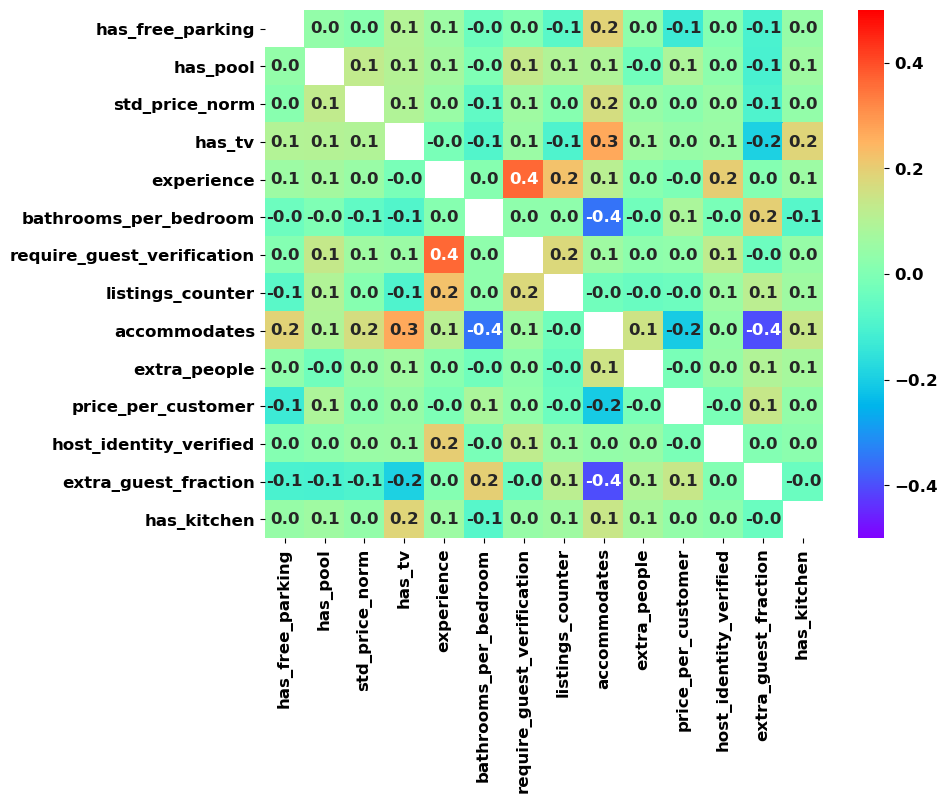

In [73]:
corr=df_listing[features["numeric"]].corr()
fig,ax = plt.subplots(figsize=[9,7])
_ = sns.heatmap(corr[corr<0.99],annot=True,fmt=".1f",vmin=-0.5,vmax=0.5, cmap=plt.get_cmap('rainbow'),ax=ax)

##### One more check before building the models
* Make sure that the data doesn't contain any infinite values
* Make sure that the data doesn't contain any non-available values

In [74]:
len(df_listing[df_listing.replace([np.inf, -np.inf], np.nan).isna().any(axis=1)])

0

<a id="model_revenue"> </a>
# Build the model that predicts the revenue

##### Encode the categorical features in the data base and store the codes in a separate dictionary

In [75]:
# save the original clean data frame with its labels 
df_listing_labels = df_listing.copy(deep=True)
for key in features["binary"]:
    df_listing_labels[key] = df_listing_labels[key].apply(lambda x: {1: "t", 0: "f"}[x])
# proceed with encoding the categorical features so that the data frame contains only numbers
features["category_encoding"] = {}
features["category_decoding"] = {}
for feature in features["categorical"]:
    a,ind=df_listing[feature].factorize()
    df_listing.loc[:,feature]=a
    features["category_encoding"][feature] = { str(key).lower(): val for val,key in enumerate(ind) }
    features["category_decoding"][feature] = { val: key for val,key in enumerate(ind)}

##### Save the training features into a list that will maintain their order

In [76]:
features["train"] = [x for x in df_listing.columns if x not in features["target"]]

##### Outliers in the target variables can have a large effect on model training, place some reasonable constraints on them (within 5 median absolute deviations from the median)

In [77]:
def get_nmad_ubound(x,nmad=5):
    med=x.median()
    # use median absolute deviation which is more robust to outliers
    # than the standard deviation
    mad=stats.median_absolute_deviation(x,nan_policy='raise')
    return med+nmad*mad
get_nmad_ubound(df_listing["mean_revenue"],5)

378.243795890411

In [78]:
get_nmad_ubound(df_listing["mean_booked"],5)

2.001482191780822

##### Booking rate can't have large outliers by it's design (it's maximum is 1) but the revenue can be very large
* Only 57 out of 3784 businesses exceed the median revenue by more than 5 median absolute deviations , which is about 1.5% of the hosts

In [79]:
revenue_max = get_nmad_ubound(df_listing["mean_revenue"],5)
len(df_listing[df_listing["mean_revenue"] >  revenue_max]), len(df_listing), round(len(df_listing[df_listing["mean_revenue"] >  revenue_max]) / len(df_listing),3)

(57, 3762, 0.015)

##### Clip the revenue so that it doesn't exceed the maximum, which is set at 5 median absolute deviations from the median

In [80]:
df_listing["mean_revenue"].clip(0,revenue_max,inplace=True)

##### Check that the clipping was done correctly

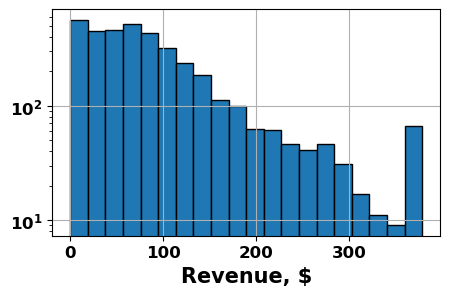

In [81]:
fig,ax=plt.subplots(figsize=[5,3])
ax=df_listing["mean_revenue"].hist(bins=20,log=True)
_=ax.set_xlabel("Revenue, $")

##### Revenue model training
* A good set of hyper parameters, e.g. learning rate eta 0.05, max_depth 5, subsample 0.7, and sampling and regularization parameters have been found by separately tuning the model   using hand scanning and with help of tools such as GridSearchCV as shown in the example function:
```python
def search_hyper_params():
    xgb1 = xgb.XGBRegressor(nthread=1, booster = 'gbtree', objective='reg:squarederror',n_estimators=10000)
    # These are the final values obtained by this grid search and by hand scanning.  Searched through several values of each of 
    # these variables plus other parameters, not listed here, that haven't improved the fit
    parameters = {
                  'eta': [0.05],
                  'max_depth': [5],
                  'subsample': [0.7],
                  'lambda': [1e2], 
                  'alpha': [0], 
                  'gamma' : [1e2],
                  'colsample_bytree': 0.7
                }
    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            cv=5,
                            n_jobs = 5,
                            verbose=True,
                            scoring='neg_root_mean_squared_error')
    xgb_grid.fit(X,y)
    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
search_hyper_params()
```


### Fit the revenue

In [82]:
def fit_revenue():
    X = df_listing[features["train"]]
    y = df_listing["mean_revenue"]
    hpars = {'eta': 0.05, 'max_depth': 5, 'subsample': 0.7, 'lambda': 1e2, 'alpha': 0, 'gamma' : 1e2, 'colsample_bytree': 0.7}
    model = xgb.XGBRegressor(objective='reg:squarederror',
                                booster = 'gbtree',
                                n_estimators=10000,
                                n_jobs=6,
                                **hpars)
    feature_importances=defaultdict(list)
    eval_metric = ['rmse','mae']
    dfs_metrics=[]
    r2_scores, explained_variance_scores = [],[]
    for run,(itrain,ival) in enumerate(KFold(n_splits=5, shuffle=True, random_state=43).split(X,y)):
        train_set = [X.iloc[itrain],y.iloc[itrain]]
        val_set=[X.iloc[ival],y.iloc[ival]]
        model.fit(*train_set,eval_set=[train_set,val_set],eval_metric=eval_metric, early_stopping_rounds=100,verbose=1000)
        val_predicted=model.predict(X.iloc[ival])
        df=pd.concat([pd.DataFrame.from_dict(model.evals_result()['validation_0'],orient='columns').add_prefix('training_'),
                      pd.DataFrame.from_dict(model.evals_result()['validation_1'],orient='columns').add_prefix('validating_')],axis=1)
        df["run"] = run
        df["epoch"] = df.index
        df["ind"] = run * 10000 + df["epoch"]
        df.set_index("ind",inplace=True)
        dfs_metrics.append(df)
        for key,val in model.get_booster().get_score(importance_type="gain").items():
            feature_importances["feature"].append(key)
            feature_importances["importance"].append(val)
            feature_importances["run"].append(run)
        r2_scores.append(r2_score(y.iloc[ival],val_predicted))
        explained_variance_scores.append(explained_variance_score(y.iloc[ival],val_predicted))
    scores={}
    scores["r2_score"] = np.array(r2_scores)
    scores["explained_variance_score"] = np.array(explained_variance_scores)
    df_metrics = pd.concat(dfs_metrics)
    df_feature_importances = pd.DataFrame.from_dict(feature_importances,orient="columns")
    return model, df_metrics, df_feature_importances, scores

In [83]:
def plot_metrics(df,title="",frm=r"{:.0f}",scaling=1.0):
    fig,ax=plt.subplots(figsize=[10,5])
    for m in [("validating_rmse","darkred"),("validating_mae","red"),("training_rmse","blue"),("training_mae","green")]:
        l=m[0]+", final value = " + frm.format(scaling * df[m[0]].tail().mean())
        sns.lineplot(x=df["epoch"],y=scaling*df[m[0]],ci="sd",ax=ax,label=l,color=m[1])
    ax.set_ylabel("Metrics")
    ax.set_xlabel("Training iteration")
    ax.set(xscale='log')
    ax.set_title(title)
    ax.grid()
    ax.legend(loc='best')
    fig.show()

In [84]:
def plot_feature_importances(df_importance):
    df=df_importance.groupby("feature")["importance"].agg(["mean","std"]).sort_values(by="mean",ascending=False)
    n = df["mean"].max()
    df["mean"] /= n
    df["std"] /= n
    fig,ax=plt.subplots(figsize=[7,7])
    sns.barplot(y=df.index,x=df["mean"],xerr=df["std"],ax=ax)
    ax.set_xlabel("Importance")
    ax.set_ylabel("")
    ax.grid()
    fig.show()

[0]	validation_0-rmse:115.86925	validation_0-mae:85.94692	validation_1-rmse:114.58652	validation_1-mae:85.34544
[1000]	validation_0-rmse:29.13540	validation_0-mae:21.77169	validation_1-rmse:44.05896	validation_1-mae:32.42249
[1263]	validation_0-rmse:26.67836	validation_0-mae:19.95954	validation_1-rmse:43.99571	validation_1-mae:32.28314
[0]	validation_0-rmse:115.11536	validation_0-mae:85.31090	validation_1-rmse:117.56928	validation_1-mae:87.84292
[894]	validation_0-rmse:30.66642	validation_0-mae:22.95410	validation_1-rmse:43.61021	validation_1-mae:33.17390
[0]	validation_0-rmse:116.48721	validation_0-mae:86.48832	validation_1-rmse:112.10563	validation_1-mae:83.10423
[823]	validation_0-rmse:30.56879	validation_0-mae:22.92742	validation_1-rmse:49.80028	validation_1-mae:36.07368
[0]	validation_0-rmse:114.71072	validation_0-mae:85.26112	validation_1-rmse:119.47266	validation_1-mae:88.39516
[1000]	validation_0-rmse:28.94632	validation_0-mae:21.69803	validation_1-rmse:46.80286	validation_1-ma

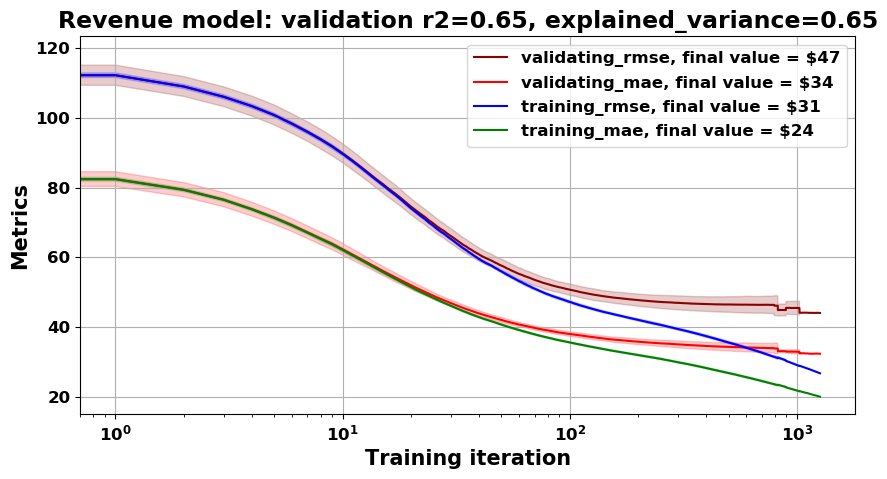

In [85]:
MRevenue,df_revenue_metrics,df_revenue_feature_importances,revenue_scores = fit_revenue()
plot_metrics(df_revenue_metrics,
             "Revenue model: validation r2={:.2f}, explained_variance={:.2f}".format(revenue_scores["r2_score"].mean(),revenue_scores["explained_variance_score"].mean()),
             "${:.0f}")

##### The above plot can be used to assess the accuracy of the model. One can either use the <em>validation data set's</em> root mean square error (more conservative), which is \\$47, or the mean absolute error, which is \\$34.  The quality of the fit can be assessed by its ability to explain variance in the validation data.  The relevant metrics are $R^{2}$ and the explained_variance.  In this fit, the two are about the same, indicating that there is no substantial bias in the fit.  Also since these metrics are reasonably high 0.65 (65%), it means that the model generalizes pretty well on validation samples that were not participating in the fit.
##### Furthermore, the plots of the normalized residuals below shows that
* Mean revenue prediction is less accurate and more biased below about \$20 prediction.
* Above 20 dollars, the residuals are reasonably flat
* <em>Normalized residuals</em> are being plotted because the revenue is an extensive measure (depends on the size of the property)

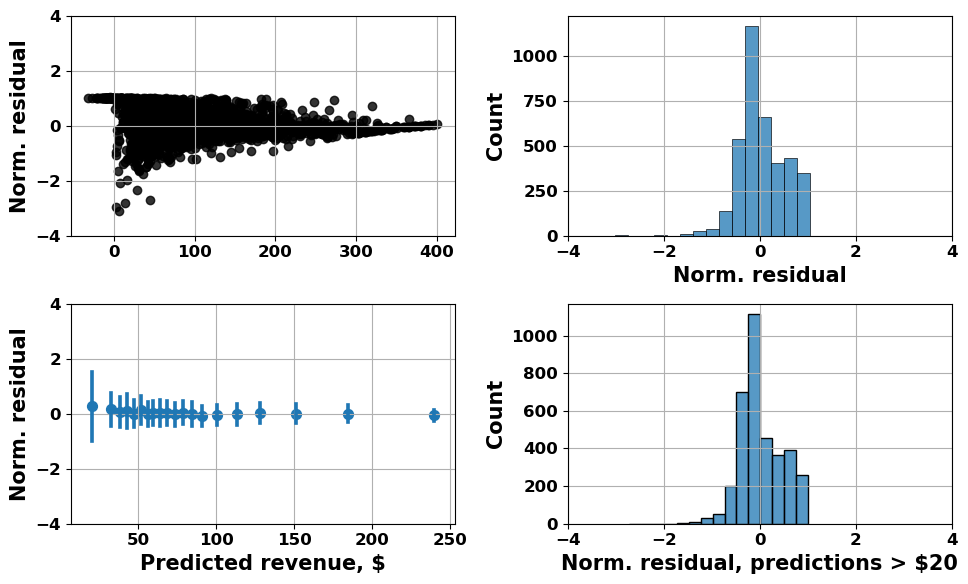

In [86]:
fig,axs=plt.subplots(nrows=2,ncols=2,tight_layout=True,figsize=[10,6])
results=df_listing[[x for x in df_listing.columns if x not in features["target"]]].copy()
results["pred"] = MRevenue.predict(results)
results["mean_revenue"] = df_listing["mean_revenue"]

sns.regplot(y=(results["pred"]-results["mean_revenue"])/results["pred"],x=results["pred"],color='black',fit_reg=False,ax=axs[0,0])
sns.regplot(y=(results["pred"]-results["mean_revenue"])/results["pred"],x=results["pred"],fit_reg=False,x_bins=20,ax=axs[1,0],ci="sd")
sns.histplot(x=(results["pred"]-results["mean_revenue"])/results["pred"],bins=50,ax=axs[0,1])

results20=results[results["pred"]>20.0]
sns.histplot(x=(results20["pred"]-results20["mean_revenue"])/results20["pred"],bins=15,ax=axs[1,1])

for ax in [axs[0,0],axs[1,0]]:
    ax.set_ylim(-4,4)
    ax.set_ylabel("Norm. residual")
axs[0,0].set_xlabel("")
axs[1,0].set_xlabel("Predicted revenue, $")
axs[0,1].set_xlabel("Norm. residual")
axs[1,1].set_xlabel("Norm. residual, predictions > $20")
for ax in [axs[0,1],axs[1,1]]:
    ax.set_xlim(-4,4)
    ax.set_ylabel("Count")
for iax in axs:
    for ax in iax:
        ax.grid()
fig.show()

### As the plot below shows, the following affects the revenue the most:
* Size of the property has the largest impact on revenue. As it has been shown before, the more people can be accommodated the larger is the revenue.
* Price per guest, room type, extra people fees, cancellation policy, and price fluctuations (changing price depending often depending on the demand) all have a strong impact on the   revenue. 
* Importance of neighborhood, amenities, host's experience, and accommodation style (e.g. bed type) are considerably smaller in comparison to the size and pricing.

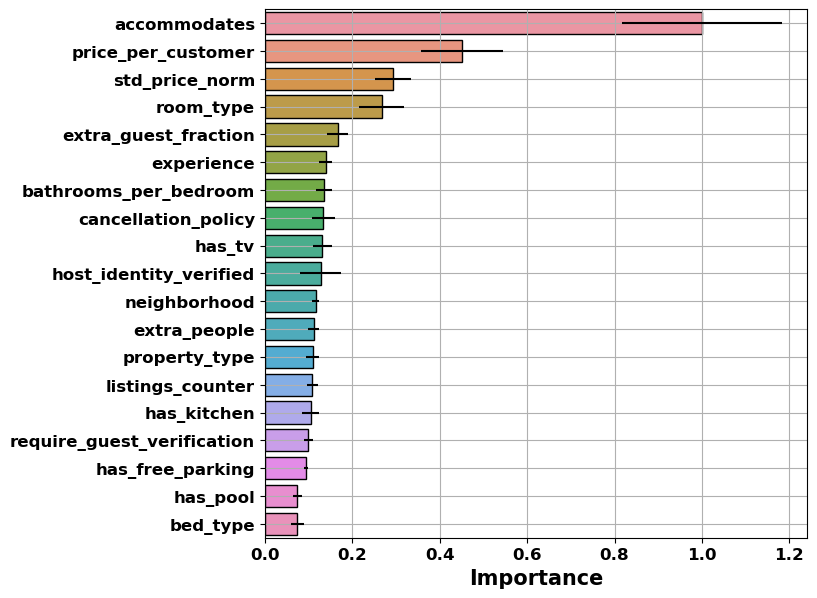

In [87]:
plot_feature_importances(df_revenue_feature_importances)

<a id = "model_booking_rate"> </a>
### Booking rate model training
* A good set of hyper parameters, e.g. learning rate eta 0.007, max_depth 15, subsample 0.7, and sampling and regularization parameters have been found by separately tuning the model using a combination of hand scanning and GridSearchCV function.

In [88]:
def fit_booking():
    target_vars=set(['mean_booked','std_booked','mean_revenue','std_revenue'])
    X = df_listing[features["train"]]
    y = df_listing["mean_booked"]
    hpars = {'eta': 0.007, 'max_depth': 15, 'subsample': 0.7, 'lambda': 100, 'alpha': 0.1, 'gamma' : 0.03, 'colsample_bytree': 0.7}
    model = xgb.XGBRegressor(objective='reg:squarederror',
                                booster = 'gbtree',
                                n_estimators=10000,
                                n_jobs=6,
                                **hpars)
    feature_importances=defaultdict(list)
    eval_metric = ['rmse','mae']
    dfs_metrics=[]
    r2_scores, explained_variance_scores = [],[]
    for run,(itrain,ival) in enumerate(KFold(n_splits=5, shuffle=True, random_state=0xbeef).split(X,y)):
        train_set = [X.iloc[itrain],y.iloc[itrain]]
        val_set=[X.iloc[ival],y.iloc[ival]]
        model.fit(*train_set,eval_set=[train_set,val_set],eval_metric=eval_metric, early_stopping_rounds=100,verbose=1000)
        val_predicted=model.predict(X.iloc[ival])
        df=pd.concat([pd.DataFrame.from_dict(model.evals_result()['validation_0'],orient='columns').add_prefix('training_'),
                      pd.DataFrame.from_dict(model.evals_result()['validation_1'],orient='columns').add_prefix('validating_')],axis=1)
        df["run"] = run
        df["epoch"] = df.index
        df["ind"] = run * 10000 + df["epoch"]
        df.set_index("ind",inplace=True)
        dfs_metrics.append(df)
        for key,val in model.get_booster().get_score(importance_type="gain").items():
            feature_importances["feature"].append(key)
            feature_importances["importance"].append(val)
            feature_importances["run"].append(run)
        r2_scores.append(r2_score(y.iloc[ival],val_predicted))
        explained_variance_scores.append(explained_variance_score(y.iloc[ival],val_predicted))
    scores={}
    scores["r2_score"] = np.array(r2_scores)
    scores["explained_variance_score"] = np.array(explained_variance_scores)
    df_metrics = pd.concat(dfs_metrics)
    df_feature_importances = pd.DataFrame.from_dict(feature_importances,orient="columns")
    return model, df_metrics, df_feature_importances,scores

[0]	validation_0-rmse:0.38549	validation_0-mae:0.35442	validation_1-rmse:0.38874	validation_1-mae:0.35662
[1000]	validation_0-rmse:0.25719	validation_0-mae:0.22147	validation_1-rmse:0.30948	validation_1-mae:0.26909
[2000]	validation_0-rmse:0.22151	validation_0-mae:0.18451	validation_1-rmse:0.30804	validation_1-mae:0.26147
[3000]	validation_0-rmse:0.19939	validation_0-mae:0.16320	validation_1-rmse:0.30893	validation_1-mae:0.25923
[4000]	validation_0-rmse:0.18405	validation_0-mae:0.14895	validation_1-rmse:0.31001	validation_1-mae:0.25805
[4469]	validation_0-rmse:0.17837	validation_0-mae:0.14383	validation_1-rmse:0.31061	validation_1-mae:0.25789
[0]	validation_0-rmse:0.38840	validation_0-mae:0.35737	validation_1-rmse:0.37690	validation_1-mae:0.34475
[1000]	validation_0-rmse:0.25809	validation_0-mae:0.22176	validation_1-rmse:0.30738	validation_1-mae:0.26242
[2000]	validation_0-rmse:0.22235	validation_0-mae:0.18492	validation_1-rmse:0.30585	validation_1-mae:0.25500
[3000]	validation_0-rmse:

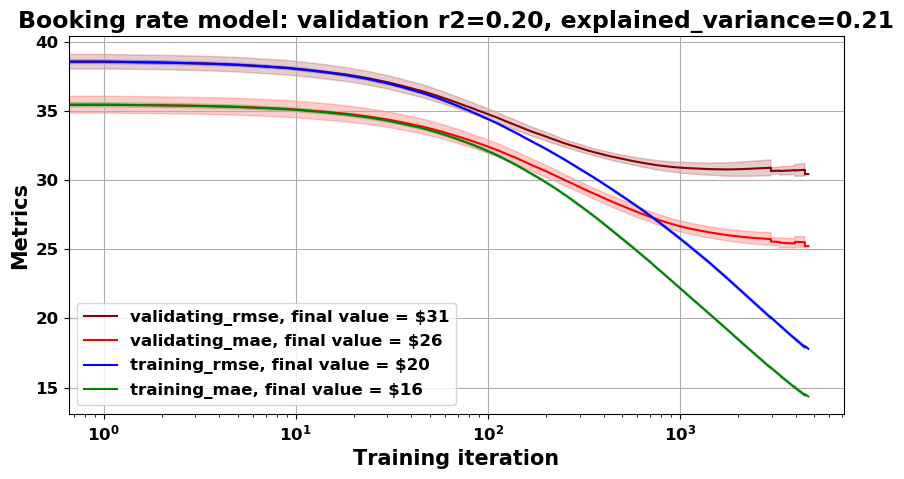

In [89]:
MBookingRate,df_booking_metrics,df_booking_feature_importances,booking_scores = fit_booking()
plot_metrics(df_booking_metrics,
             "Booking rate model: validation r2={:.2f}, explained_variance={:.2f}".format(booking_scores["r2_score"].mean(),booking_scores["explained_variance_score"].mean()),
             "${:.0f}",100.0)

##### The above plot can be used to assess the accuracy of the model. One can either use the validating data set root mean square error (more conservative), which is 31%, or the mean absolute error, which is 26%.  
* Given that the standard deviation of the booking rate was determined earlier to be 35%, the accuracy of the booking rate model is not as impressive as the performance of the revenue model, as further evidenced by the validation R2 and explained_variance values of about 0.2 (20%) each. The reason for this is that the present data set does not have sufficient numbers of variables that are strongly correlated with the booking rate.
* The booking rate model can be potentially improved with customer review data, more property quality data, and customer seasonal preferences data compiled over several years prior to the prediction year.   
* Nevertheless, the model can be used to give a general idea of what one should expect for the booking rate and what is the relative importance for the booking rate of the presently available features 
##### The plots below shows that
* Mean booking rate prediction is more biased towards larger booking probabilities below 45% booking rate.
* Above the prediction of 45% booking, the residuals become reasonably flat with the standard deviation of about 18%

22.32195471676425


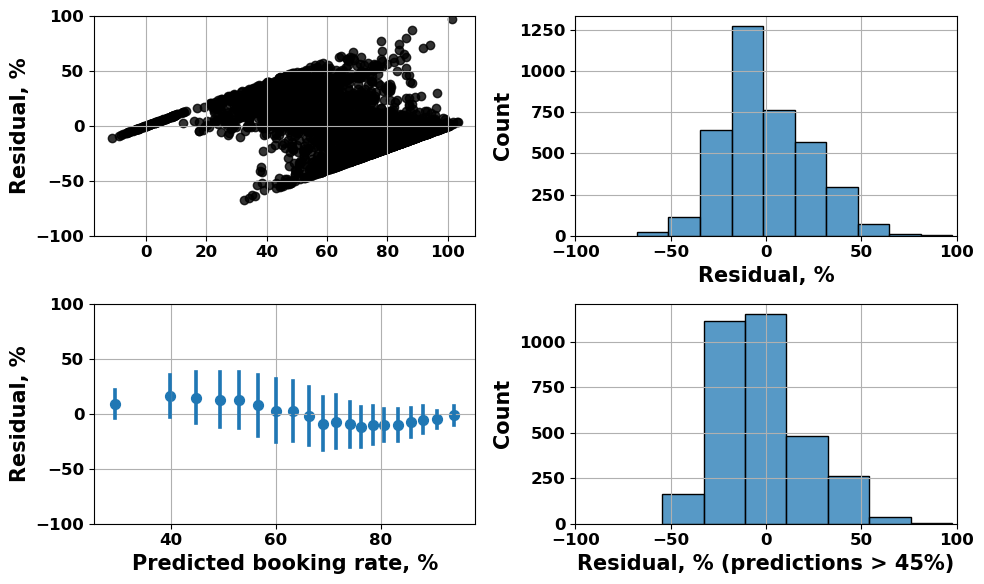

In [90]:
fig,axs=plt.subplots(nrows=2,ncols=2,tight_layout=True,figsize=[10,6])
results=df_listing[[x for x in df_listing.columns if x not in features["target"]]].copy()
results["pred"] = MBookingRate.predict(results)
results["mean_booked"] = df_listing["mean_booked"]

sns.regplot(y=100.0*(results["pred"]-results["mean_booked"]),x=100.0*results["pred"],color='black',fit_reg=False,ax=axs[0,0])
sns.regplot(y=100.0*(results["pred"]-results["mean_booked"]),x=100.0*results["pred"],fit_reg=False,x_bins=20,ax=axs[1,0],ci="sd")
sns.histplot(x=100.0*(results["pred"]-results["mean_booked"]),bins=10,ax=axs[0,1])

results45=results[results["pred"]>0.45]
sns.histplot(x=100.0*(results45["pred"]-results45["mean_booked"]),bins=7,ax=axs[1,1])
print(100.0*(results45["pred"]-results45["mean_booked"]).std())

for ax in [axs[0,0],axs[1,0]]:
    ax.set_ylim(-100,100)
    ax.set_ylabel("Residual, %")
axs[0,0].set_xlabel("")
axs[1,0].set_xlabel("Predicted booking rate, %")
axs[0,1].set_xlabel("Residual, %")
axs[1,1].set_xlabel("Residual, % (predictions > 45%)")
for ax in [axs[0,1],axs[1,1]]:
    ax.set_xlim(-100,100)
    ax.set_ylabel("Count")
for iax in axs:
    for ax in iax:
        ax.grid()
fig.show()

### The plots below show the relative importance of features on the booking rate.  It can be seen that
* Price fluctuation has the largest impact on the booking rate.  Room type is the next in the importance list.
* Host's experience, price per customer, cancellation policy, listings counter, neighborhood  are next in line of the importance and have roughly similar relative contributions. 

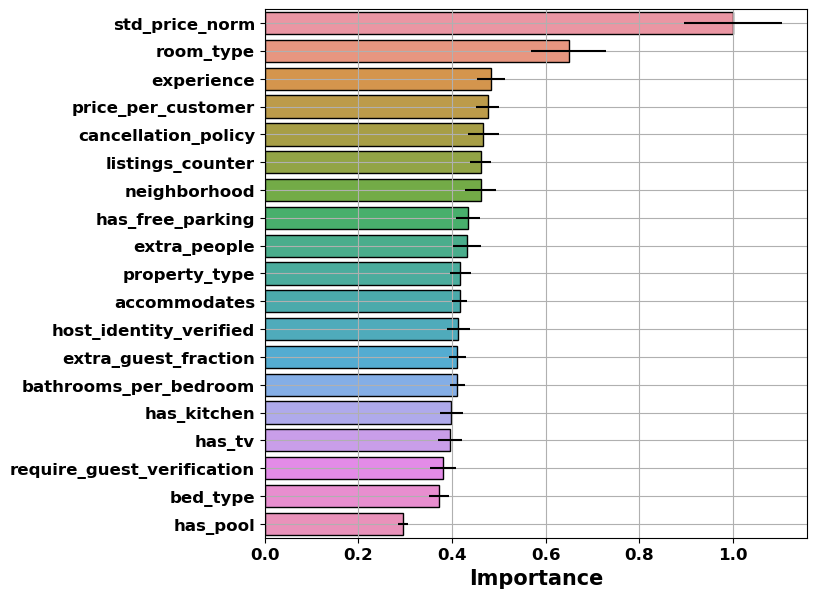

In [91]:
plot_feature_importances(df_booking_feature_importances)

<a id = "model_prediction"></a>
### Model prediction interface function
* Accept a data frame with the training variables as an input (training columns should be the same as in the data frame used for training)
* Encode the binary and categorical features according to the same exact rules as were used for the model training
* Return a data frame with two columns that contains the predicted revenue and the predicted booking rate

In [92]:
# If a clean data frame with the training features is provided
def predict_from_df(df):
    X=df[features["train"]].copy()
    # encode the values according to the same exact rules as
    # it was done for the training
    for k in X.columns:
        if k in features["binary"]:
            X[k] = X[k].apply(lambda x: {'t' : int(1), 'f' : int(0)}[str(x).lower()] if str(x).lower() in ['t', 'f'] else x)
        if k in features["categorical"]:
            X[k] = X[k].apply(lambda x: int(features["category_encoding"][k][str(x).lower()]) if str(x).lower() in features["category_encoding"][k].keys() else x)
    X=X.apply(pd.to_numeric,errors='coerce')
    pred_revenue = MRevenue.predict(X)
    pred_booking_rate = MBookingRate.predict(X)
    df_pred = pd.DataFrame(index=df.index)
    df_pred["predicted_revenue"] = pred_revenue
    df_pred["predicted_booking_rate_percent"] = 100.0 * pred_booking_rate
    df_pred["predicted_revenue"].clip(lower=0,inplace=True)
    df_pred["predicted_booking_rate_percent"].clip(lower=0,upper=100.0,inplace=True)
    return df_pred

# Most probable values of the training variables.  Used by predict_from_dict for values
# that have not been specified.
train_mpv = {key: df_listing_labels[key].value_counts().idxmax() for key in features["train"]}
    
# make predictions by passing model parameters through the dictionary.  Minimum required values
# are accomodates variable and the price_per_customer
def predict(**input_dict):
    if "location" in map(lambda x: x.lower(), input_dict.keys()):
        input_dict["neighborhood"] = input_dict["location"]
        del input_dict["location"]
    for key in ["accommodates","price_per_customer"]:
        if key not in input_dict.keys():
            print("ERROR: must have '{:s}' in your inputs".format(key),file=sys.stderr)
            return None
    d=train_mpv.copy()   # place the most probable values first
    for key,val in input_dict.items():
        if key not in features["train"]:
            print("WARNING: {{ '{:s}' : {:s} }} is not used by the model".format(str(key),str(val)),file=sys.stderr)
            continue
        if key in features["binary"] and  str(val).lower() not in ["t","f"]:
            print("WARNING: {{ '{:s}' : '{:s}' }} is not used by the model; use ['t','f'] values only".format(str(key),str(val)),file=sys.stderr)
            continue
        if key in features["categorical"] and  str(val).lower() not in features["category_encoding"][key].keys():
            print("WARNING: {{ '{:s}' : '{:s}' }} is not used by the model; use {:s} values only".
                  format(str(key),str(val),str([x for _,x in features["category_decoding"][key].items()])),file=sys.stderr)
            continue
        d.update({key:val}) # update
    df = pd.DataFrame(columns=features["train"])
    df = df.append(d , ignore_index=True)
    return predict_from_df(df)

# function that lists all available options for the model inputs
def get_options():
    d={}
    for key in train_mpv.keys():
        if key in features["categorical"]:
            d[key] = [x for _,x in features["category_decoding"][key].items()]
        if key in features["binary"]:
            d[key] = ["t","f"]
        if key not in (features["binary"] | features["categorical"]):
            d[key] = [df_listing[key].min(),df_listing[key].max()]
    return d

# function that lists the default inputs to the model (most probable values)
def get_defaults():
    return train_mpv.copy()

# given a query string, return typical price per customer and the number of people the
# business accommodates
def get_typical_price_and_size(query_str="",additional=None):
    if len(query_str) == 0:
        return df_listing_labels
    x=df_listing_labels.query(query_str)
    price_per_customer = x["price_per_customer"].value_counts().idxmax()
    accommodates = x["accommodates"].value_counts().idxmax()
    d={"price_per_customer": price_per_customer, "accommodates": accommodates}
    if(additional):
        if type(additional) != list:
            d.update({additional: x[additional].mean()})
        else:
            for a in additional:
                d.update({a: x[a].mean()}) 
    return d


### Prediction for the default (most probable) host scenario

In [93]:
# prediction for the default (most probable scenario)
predict(**get_defaults())

,predicted_revenue,predicted_booking_rate_percent
0,59.071465,58.839767


### Predictions for 3 chosen scenarios: 
* 1 person apartment in Downtown area (\\$50 per guest typical price, \\$11 for extra people ):
    * \\$32 expected daily revenue
    * 45\% expected daily booking rate
* 2 person house in Lake City (\\$40 per guest typical price, \\$14 for extra people )
    * \\$52 expected daily revenue
    * 79\% expected daily booking rate
* 4 person house in Magnolia (\$35 per guest typical price, \\$13 for extra people)
    * \\$94 expected daily revenue
    * 66\% expected daily booking rate

In [94]:
print(get_typical_price_and_size("neighborhood=='Downtown'",["extra_people"]))
print(get_typical_price_and_size("neighborhood=='Lake City'",["extra_people"]))
print(get_typical_price_and_size("neighborhood=='Magnolia'",["extra_people"]))

{'price_per_customer': 50.0, 'accommodates': 2, 'extra_people': 10.815533980582524}
{'price_per_customer': 40.0, 'accommodates': 2, 'extra_people': 13.753846153846155}
{'price_per_customer': 35.0, 'accommodates': 2, 'extra_people': 12.60655737704918}


In [95]:
predict(price_per_customer=50.0,accommodates=1,property_type="Apartment",neighborhood="Downtown",extra_people=11.0)

,predicted_revenue,predicted_booking_rate_percent
0,31.890907,45.129181


In [96]:
predict(accommodates=2,price_per_customer=40,property_type='House',neighborhood='Lake City',extra_people=14)

,predicted_revenue,predicted_booking_rate_percent
0,52.032665,78.955704


In [97]:
predict(price_per_customer=35,accommodates=4,property_type='House',neighborhood='Magnolia',extra_people=13)

,predicted_revenue,predicted_booking_rate_percent
0,93.960579,66.37326


<a id = "summary"> </a>
# Summary

* The revenue and the booking rate decrease around Christmas, New Year, Easter, and the Fourth of July.  Market prices surge and the revenues increases during the summer, when there is an increased demand for the Airbnb hosts due to the increased number of people taking vacations. 

* As expected, higher guest pricing, larger accommodations, stricter cancellation policies, and larger fees for extra guests all increase the revenue.  Price per customer and the number of people accommodated are the most important parameters. Price changes for the high and low demand also increase the revenue, as evidenced by the importance of the price fluctuation on the prediction of the revenue and its positive correlation with the revenue.

* The revenue and the booking rate models can provide practical estimations of the expected daily revenue and the booking rate for specified sets of host's property attributes, pricing, policies, and location.
  
* The models can be improved by using more data and by considering more features, such as guests reviews, customers' seasonal preferences, and additional property's quality and appeal factors.
